In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from atomsci.ddm.pipeline import diversity_plots as dp
from scipy.spatial.distance import pdist, squareform
import matplotlib.patches as mpatches
import math
import torch
import numpy as np
# import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import shutil
import sys
sys.path.append('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/')
sys.path.append('../')
from RF_functions import *
from training_functions import *
from dataset import * 
from imblearn.over_sampling import SMOTEN, ADASYN, SMOTE
from sklearn.metrics import accuracy_score, balanced_accuracy_score,precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix,matthews_corrcoef
import warnings
warnings.filterwarnings('ignore')
from rdkit import Chem
from rdkit.Chem import AllChem



import sklearn
from sklearn.model_selection import KFold

import imblearn as imb
# print("imblearn version: ",imblearn.__version__)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import itertools

# from scipy.stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import sys


from sklearn.model_selection import GridSearchCV



Skipped loading some Jax models, missing a dependency. No module named 'haiku'


In [2]:
# method to translate ecfp fingerprints in DF back to bitvectors
from rdkit.DataStructs import ExplicitBitVect
def df_to_bitvect(df):
    bitvects = []
    for _, row in df.iterrows():
        bit_string = ''.join(row.astype(str))
        bitvect = ExplicitBitVect(len(bit_string))
        for i, bit in enumerate(bit_string):
            if bit == '1':
                bitvect.SetBit(i)
        bitvects.append(bitvect)
    return bitvects

In [3]:
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import getpass, os

In [4]:
from atomsci.ddm.pipeline import chem_diversity as cd
from atomsci.ddm.pipeline import dist_metrics
import logging
import matplotlib.pyplot as plt


In [14]:
# method to translate ecfp fingerprints in DF back to bitvectors
from rdkit.DataStructs import ExplicitBitVect
def df_to_bitvect(df):
    bitvects = []
    for _, row in df.iterrows():
        bit_string = ''.join(row.astype(str))
        bitvect = ExplicitBitVect(len(bit_string))
        for i, bit in enumerate(bit_string):
            if bit == '1':
                bitvect.SetBit(i)
        bitvects.append(bitvect)
    return bitvects

In [27]:
def get_tani_dist_distr(df, smiles_col, radius=2, subset_col='subset', subsets=True, 
                         ref_subset='test'):
    num_cmpds = len(df)
    feat_type = 'ecfp'
    dist_metric = 'tanimoto'
    calc_type='nearest'
    num_nearest=1
    dists=pd.DataFrame([], columns=['dist','subset'])
    for subs in df[subset_col].unique():
        if subs==ref_subset:
            continue
        smiles_arr1 = df.loc[df[subset_col]==ref_subset, smiles_col].values 
        smiles_arr2 = df.loc[df[subset_col]==subs, smiles_col].values
        fprints1_df=df.loc[df['subset']==ref_subset, [col for col in df.columns if 'ecfp' in col]]
        fprints2_df=df.loc[df['subset']==subs, [col for col in df.columns if 'ecfp' in col]]
        
        fprints1=df_to_bitvect(fprints1_df)
        fprints2=df_to_bitvect(fprints2_df)
        
        
        within_dset=False
        diststmp=cd.calc_summary(dist_metrics.tanimoto(fprints1, fprints2), calc_type, num_nearest, within_dset)
                
        # diststmp = cd.calc_dist_smiles(feat_type, dist_metric, smiles_arr2, smiles_arr2=smiles_arr1, calc_type='nearest', num_nearest=1)

        # diststmp = diststmp.flatten()
        substmp=[subs]*len(diststmp)
        diststmp = pd.DataFrame(zip(diststmp,substmp), columns=['dist','subset'])
        dists=pd.concat([dists,diststmp])
    dists=dists.reset_index(drop=True)
    return dists

In [24]:
datapath = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/datasets/80train_20test/featurized/'
nek2_mfp = pd.read_csv(f'{datapath}NEK2_binding_MFP_none_scaled.csv') 
mfp_dict = {}
for i in range (2048): 
    mfp_dict[i] = f'ecfp_2048_{i}'

In [5]:
common_cols = ['base_rdkit_smiles', 'active', 'subset']
datapath = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/datasets/80train_20test/featurized/'
for nek in neks: 
    this_nek = f'{nek}'
    print(this_nek)
    mfp_desc = pd.read_csv(f'{datapath}{nek}_MFP_none_scaled.csv') 

    og_test= mfp_desc[mfp_desc['subset']=='test']
    og_train = mfp_desc[mfp_desc['subset']=='train']
    num_train = og_train.shape[0]
    # display(og_train)
    
    # moe_under = pd.read_csv(f'{datapath}NEK{nek}/{short}/NEK{nek}_{bi}_moe_UNDER_df.csv')
    mfp_under = pd.read_csv(f'{datapath}{nek}_MFP_UNDER.csv')
    # under = moe_under.merge(mfp_under, on=['compound_id', 'base_rdkit_smiles', 'subset', 'fold', 'active'])
    under = mfp_under[mfp_under['subset'] == 'train']
    under['subset'] = 'UNDER' 

    
    original_compounds = pd.concat([og_test,og_train, under])
    original_compounds= original_compounds.rename(columns=mfp_dict)
    
    # moe_smote = pd.read_csv(f'{datapath}NEK{nek}/{short}/NEK{nek}_{bi}_moe_SMOTE_df.csv')
    mfp_smote = pd.read_csv(f'{datapath}{nek}_MFP_SMOTE.csv') 
    mfp_smote= mfp_smote.rename(columns=mfp_dict)
    # mfp_smote = mfp_smote.drop(columns=common_cols)
    
    # smote = pd.concat([moe_smote, mfp_smote], axis=1)
    smote_train =mfp_smote[mfp_smote['subset'] == 'train'].copy()
    new_smote=smote_train.iloc[num_train:].copy()
    new_smote['subset'] = 'SMOTE'
    

    df_all = pd.concat([original_compounds, new_smote])
    print(df_all['subset'].value_counts())
    

    dists,fig,ax=plot_tani_dist_distr(df_all, 'base_rdkit_smiles', this_nek, ref_subset='test',radius=2, subsets=True, featurized=True)
    fig.savefig(f'kde_train_dists/{nek}_tanimoto_dists_from_TEST.png', bbox_inches='tight',dpi=300)



NameError: name 'neks' is not defined

[ 89250 773956 654571 438878 433015 858597  85945 697368 201469  94177]


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK2_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK2_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK2_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK2_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK2_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,NEK2_binding,kdb_2524,COc1cc(Nc2ncc3c(C)nc(-c4cc5ccccc5[nH]4)n3n2)cc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
293,NEK2_binding,kdb_2825,C[C@@H](Oc1cc(-n2cnc3cc(-c4cnn(C)c4)ccc32)sc1C...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
294,NEK2_binding,kdb_2826,CSc1nn2c(=O)cc(N3CCOCC3)nc2n1Cc1cccc(C(F)(F)F)c1C,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
295,NEK2_binding,kdb_2887,Cc1ccc(CC(=O)N2CCc3cc(-c4cn(C)c5ncnc(N)c45)ccc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK2_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK2_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK2_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK2_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK2_binding,kdb_103,CCCCCCCCCCCCCCCCCCOP(=O)([O-])OC1CC[N+](C)(C)CC1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,NEK2_binding,kdb_2519,N#Cc1cnc2cc(-c3cnc(CNCCN4CCOCC4)s3)ccc2c1Nc1cc...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
293,NEK2_binding,kdb_2692,C[C@@H](Oc1cc(-n2cnc3cc(-c4ccncc4)ccc32)sc1C(N...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
294,NEK2_binding,kdb_2740,COc1cc(Nc2nccc(-c3c(-c4cccc(NC(=O)c5c(F)cccc5F...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
295,NEK2_binding,kdb_2758,c1ccc(-c2ccnc3[nH]ccc23)cc1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK2_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK2_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK2_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK2_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK2_binding,kdb_104,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/C=C/C...,train,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,NEK2_binding,kdb_2698,O=c1[nH]ccc2nc(N[C@@H]3CCCNC3)nc(Nc3ccc(S(=O)(...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
293,NEK2_binding,kdb_2785,Nc1ncc(-c2cccnc2)c2scc(-c3ccc4c(c3)CCN4C(=O)Cc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
294,NEK2_binding,kdb_2823,CC(C)Oc1ccc2c(-c3ccnc(Nc4ccc(N5CCN(C)CC5)cc4)n...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
295,NEK2_binding,kdb_2857,CCCCc1nn2ncccc2c1-c1ccnc(Nc2ccc(N3CCN(C)CC3)cc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK2_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK2_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK2_binding,kdb_103,CCCCCCCCCCCCCCCCCCOP(=O)([O-])OC1CC[N+](C)(C)CC1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK2_binding,kdb_104,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/C=C/C...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK2_binding,kdb_1040,Cc1cccc(NC(=O)Nc2ccc(-c3cncc4c3c(N)nn4C)cc2)c1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,NEK2_binding,kdb_2721,Cn1cc(-c2ccc3c(c2)CCN3C(=O)Cc2cccc(F)c2)c2c(N)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
293,NEK2_binding,kdb_2768,CNC(=O)c1ccccc1Nc1nc(Nc2ccc(N3CCOCC3)cc2)ncc1Cl,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
294,NEK2_binding,kdb_2896,Nc1ncc(-c2cn[nH]c2)c2scc(-c3ccc4c(c3)CCN4C(=O)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
295,NEK2_binding,kdb_29,Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK2_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK2_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK2_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK2_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,NEK2_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,NEK2_binding,kdb_2448,Nc1ncnc2occ(-c3ccc4c(c3)CCN4C(=O)Cc3cc(F)ccc3F...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
293,NEK2_binding,kdb_2606,O=C1NC(=O)C(c2ccccc2Cl)=C1Nc1ccccc1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
294,NEK2_binding,kdb_2610,Cn1cc(-c2ccc3c(c2)CCN3C(=O)Cc2ccccc2Cl)c2c(N)n...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
295,NEK2_binding,kdb_2894,COc1ccc(Nc2ncc(C#N)c(Nc3ccccc3C(N)=O)n2)cc1N1C...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK2_inhibition,kdb_1001,Nc1nonc1-n1nnc(C(=O)NN=Cc2cccs2)c1-c1ccccc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK2_inhibition,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK2_inhibition,kdb_1005,CN(C)c1cccc2c(S(=O)(=O)N(CCN)c3cncc(-c4ccc5cnc...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK2_inhibition,kdb_1006,N#Cc1ncc2nc1OCCCCCOc1cc(CCCO)c(Cl)cc1NC(=O)N2,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK2_inhibition,kdb_1007,NC(=O)c1cn(-c2ccc(O)cc2Cl)c2cc(-c3ccncc3)ccc2c1=O,train,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,NEK2_inhibition,kdb_3754,CN1CCN(c2ccc(Nc3ncc4c(n3)N3c5ccccc5CC3C(=O)N4C...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
501,NEK2_inhibition,kdb_3767,COc1cc(N2CCN(C)CC2)ccc1Nc1ncc2c(n1)N1c3ccccc3C...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502,NEK2_inhibition,kdb_3771,COc1cc(C(=O)N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc2c...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
503,NEK2_inhibition,kdb_3772,CCOc1cc(N2CCC(O)CC2)ccc1Nc1ncc2c(n1)n1c(cc3ccc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK2_inhibition,kdb_1000,Oc1ccc(-c2n[nH]c(Nc3cccc(Cl)c3)c2-c2ccc(O)cc2)cc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK2_inhibition,kdb_1001,Nc1nonc1-n1nnc(C(=O)NN=Cc2cccs2)c1-c1ccccc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK2_inhibition,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK2_inhibition,kdb_1004,COc1ccc(C=C2C(=O)ON=C2c2ccc(Br)cc2)cc1OC,train,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,NEK2_inhibition,kdb_1005,CN(C)c1cccc2c(S(=O)(=O)N(CCN)c3cncc(-c4ccc5cnc...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,NEK2_inhibition,kdb_3748,CCN1CCN(c2ccc(Nc3ncc4c(n3)n3c(cc5ccccc53)c(=O)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
501,NEK2_inhibition,kdb_3750,CN1CCN(C2CCN(c3ccc(Nc4ncc5c(n4)n4c(cc6ccccc64)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502,NEK2_inhibition,kdb_762,O=C(O)c1ccccc1Nc1ccnc(Nc2ccc3cn[nH]c3c2)n1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
503,NEK2_inhibition,kdb_832,CC(=O)N1CCN(C2CCC(n3nc(-c4ccc(NC(=O)c5cc6ccccc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK2_inhibition,kdb_1000,Oc1ccc(-c2n[nH]c(Nc3cccc(Cl)c3)c2-c2ccc(O)cc2)cc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK2_inhibition,kdb_1001,Nc1nonc1-n1nnc(C(=O)NN=Cc2cccs2)c1-c1ccccc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK2_inhibition,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK2_inhibition,kdb_1004,COc1ccc(C=C2C(=O)ON=C2c2ccc(Br)cc2)cc1OC,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK2_inhibition,kdb_1006,N#Cc1ncc2nc1OCCCCCOc1cc(CCCO)c(Cl)cc1NC(=O)N2,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,NEK2_inhibition,kdb_3770,CN1CCN(c2ccc(Nc3ncc4c(n3)n3c(cc5ccccc53)c(=O)n...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
501,NEK2_inhibition,kdb_750,CCCn1cc(-c2cnc(N)c3c(-c4ccc(NC(=O)Nc5cccc(F)c5...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502,NEK2_inhibition,kdb_809,Cc1ccc(NC(=O)Nc2ccc(-c3csc4c(-c5cnn(C(C)C(=O)N...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
503,NEK2_inhibition,kdb_821,Cn1cc(-c2cnc(N)c3c(-c4ccc(NC(=O)Nc5ccc(OC(F)F)...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK2_inhibition,kdb_1000,Oc1ccc(-c2n[nH]c(Nc3cccc(Cl)c3)c2-c2ccc(O)cc2)cc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK2_inhibition,kdb_1004,COc1ccc(C=C2C(=O)ON=C2c2ccc(Br)cc2)cc1OC,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK2_inhibition,kdb_1005,CN(C)c1cccc2c(S(=O)(=O)N(CCN)c3cncc(-c4ccc5cnc...,train,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK2_inhibition,kdb_1006,N#Cc1ncc2nc1OCCCCCOc1cc(CCCO)c(Cl)cc1NC(=O)N2,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK2_inhibition,kdb_1007,NC(=O)c1cn(-c2ccc(O)cc2Cl)c2cc(-c3ccncc3)ccc2c1=O,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,NEK2_inhibition,kdb_778,CNC(=O)C(C)n1cc(-c2cnc(N)c3c(-c4ccc(NC(=O)Nc5c...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499,NEK2_inhibition,kdb_788,Cc1cccc(NC(=O)Nc2ccc(-c3csc4c(C#CCNS(C)(=O)=O)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
500,NEK2_inhibition,kdb_799,CC(O)Cn1cc(-c2cnc(N)c3c(-c4ccc(NC(=O)Nc5cccc(F...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
501,NEK2_inhibition,kdb_911,CCN(CC)CCNC(=O)C=Cc1cnc(N)c2c(-c3ccc(NC(=O)Nc4...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK2_inhibition,kdb_1000,Oc1ccc(-c2n[nH]c(Nc3cccc(Cl)c3)c2-c2ccc(O)cc2)cc1,train,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK2_inhibition,kdb_1001,Nc1nonc1-n1nnc(C(=O)NN=Cc2cccs2)c1-c1ccccc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK2_inhibition,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK2_inhibition,kdb_1004,COc1ccc(C=C2C(=O)ON=C2c2ccc(Br)cc2)cc1OC,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK2_inhibition,kdb_1005,CN(C)c1cccc2c(S(=O)(=O)N(CCN)c3cncc(-c4ccc5cnc...,train,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,NEK2_inhibition,kdb_3763,CN1C(=O)C2Cc3ccccc3N2c2nc(Nc3ccc(N4CCOCC4)cc3)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499,NEK2_inhibition,kdb_3773,COc1cc(C(=O)N2CCN(C)CC2)ccc1Nc1ncc2c(n1)n1c(cc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
500,NEK2_inhibition,kdb_789,O=C1NCCc2[nH]c(-c3ccnc(C=Cc4ccccc4)c3)cc21,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
501,NEK2_inhibition,kdb_902,O=C(Cc1ccccc1)Nc1cccc(-c2nc3sccn3c2-c2ccnc(Nc3...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK3_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK3_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,NEK3_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK3_binding,kdb_103,CCCCCCCCCCCCCCCCCCOP(=O)([O-])OC1CC[N+](C)(C)CC1,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK3_binding,kdb_105,OCCn1cc(-c2cnc3nnn(Cc4ccc5ncccc5c4)c3n2)cn1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,NEK3_binding,kdb_2918,Cc1cnc2c(-c3ccncc3)c(-c3ccc(F)cc3)nn2c1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
323,NEK3_binding,kdb_2922,Cc1ccc2c(-c3ccc4[nH]ncc4c3)c(-c3ccc(F)cc3)nn2n1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324,NEK3_binding,kdb_2934,CC(C)(C)OC(=O)NCCCNS(=O)(=O)c1ccc(Nc2ncc3c(n2)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
325,NEK3_binding,kdb_2955,c1cncc(-c2ccc3nc(Nc4ccc(CN5CCOCC5)cc4)ncc3c2)c1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK3_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK3_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK3_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK3_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,NEK3_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,NEK3_binding,kdb_2600,COc1ccc(Nc2nccc(N3CCC(NC(=O)C(C)c4ccc(Cl)cc4)C...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
323,NEK3_binding,kdb_2657,Cc1ccc2c(-c3ccnc(Nc4ccc(C(F)(F)F)cc4)n3)cnn2n1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324,NEK3_binding,kdb_2808,COc1cc(Nc2nccc(N3CCC(NC(=O)c4cccc(NC(C)=O)c4)C...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
325,NEK3_binding,kdb_3024,CCCNc1ccc2ncc(-c3ccnc(C)c3)n2n1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK3_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK3_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK3_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK3_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK3_binding,kdb_104,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/C=C/C...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,NEK3_binding,kdb_2268,Nc1nonc1-n1ncc2c(NC(=O)c3ccccc3Cl)cccc21,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324,NEK3_binding,kdb_2563,COc1cc(Nc2nccc(N3CCC(NS(=O)(=O)c4ccc(NC(C)=O)c...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
325,NEK3_binding,kdb_2894,COc1ccc(Nc2ncc(C#N)c(Nc3ccccc3C(N)=O)n2)cc1N1C...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326,NEK3_binding,kdb_3019,NC[C@@H](NC(=O)c1ccc2scnc2c1)c1ccccc1,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK3_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK3_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK3_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK3_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK3_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,NEK3_binding,kdb_2958,Cc1cc(OCCN2CCOCC2)ccc1-c1cc2c(-c3ccc(C(=O)O)cc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
322,NEK3_binding,kdb_2986,CCOc1ccc2c(-c3ccnc(Nc4cccc(OC(F)(F)F)c4)n3)cnn2n1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
323,NEK3_binding,kdb_2987,CCOc1ccc2c(-c3ccnc(Nc4cc(N5CCOCC5)cc(C(F)(F)F)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324,NEK3_binding,kdb_3026,COc1ccccc1C1=C(Nc2cccc(C#N)c2)C(=O)NC1=O,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK3_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK3_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK3_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK3_binding,kdb_103,CCCCCCCCCCCCCCCCCCOP(=O)([O-])OC1CC[N+](C)(C)CC1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK3_binding,kdb_104,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/C=C/C...,train,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,NEK3_binding,kdb_2698,O=c1[nH]ccc2nc(N[C@@H]3CCCNC3)nc(Nc3ccc(S(=O)(...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
322,NEK3_binding,kdb_2924,Cc1ccn2c(-c3ccncc3)c(-c3ccc(F)cc3)nc2n1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
323,NEK3_binding,kdb_3055,CS(=O)(=O)c1ccc(-c2cnc(N)c(C(=O)Nc3ccccc3)n2)cc1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324,NEK3_binding,kdb_3507,N#Cc1ccc(Nc2ccc3[nH]c(=O)[nH]c3c2)c(Cl)c1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK5_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,NEK5_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK5_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK5_binding,kdb_1048,COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK5_binding,kdb_1081,CC(C)(O)c1nnc2ccc(-c3c(-c4ccc(F)cc4F)nc4n3CCC4...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,NEK5_binding,kdb_2843,CCNCC(Cc1ccccc1)NC(=O)c1cc(Br)c(-c2ccnc3[nH]cc...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
318,NEK5_binding,kdb_2986,CCOc1ccc2c(-c3ccnc(Nc4cccc(OC(F)(F)F)c4)n3)cnn2n1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
319,NEK5_binding,kdb_3051,N#Cc1cnc(Nc2cccc(NC(=O)N3CCCC3)c2)nc1NCCCNC(=O...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
320,NEK5_binding,kdb_89,Cc1cnc(Nc2ccc(OCCN3CCCC3)cc2)nc1Nc1cccc(S(=O)(...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK5_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK5_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK5_binding,kdb_1048,COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK5_binding,kdb_105,OCCn1cc(-c2cnc3nnn(Cc4ccc5ncccc5c4)c3n2)cn1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK5_binding,kdb_1081,CC(C)(O)c1nnc2ccc(-c3c(-c4ccc(F)cc4F)nc4n3CCC4...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,NEK5_binding,kdb_2631,NCC(NC(=O)c1cc(-c2cn[nH]c2)c(-c2ccnc3[nH]ccc23...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
318,NEK5_binding,kdb_2768,CNC(=O)c1ccccc1Nc1nc(Nc2ccc(N3CCOCC3)cc2)ncc1Cl,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
319,NEK5_binding,kdb_2825,C[C@@H](Oc1cc(-n2cnc3cc(-c4cnn(C)c4)ccc32)sc1C...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
320,NEK5_binding,kdb_3053,O=C(NCCCNc1nc(Nc2cccc(NC(=O)N3CCCC3)c2)ncc1I)C...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK5_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK5_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK5_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK5_binding,kdb_1048,COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK5_binding,kdb_105,OCCn1cc(-c2cnc3nnn(Cc4ccc5ncccc5c4)c3n2)cn1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,NEK5_binding,kdb_2808,COc1cc(Nc2nccc(N3CCC(NC(=O)c4cccc(NC(C)=O)c4)C...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
316,NEK5_binding,kdb_2840,COc1cc(Nc2nccc(-c3c(-c4cccc(NC(=O)c5c(F)cccc5F...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
317,NEK5_binding,kdb_2884,CN1CCN(Cc2ccc(NC(=O)Nc3ccc(N(C)c4ccnc(Nc5ccc(C...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
318,NEK5_binding,kdb_2899,NCCC(NC(=O)c1cc(Br)c(-c2ccnc3[nH]ccc23)s1)c1cc...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK5_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK5_binding,kdb_1048,COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK5_binding,kdb_105,OCCn1cc(-c2cnc3nnn(Cc4ccc5ncccc5c4)c3n2)cn1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK5_binding,kdb_1081,CC(C)(O)c1nnc2ccc(-c3c(-c4ccc(F)cc4F)nc4n3CCC4...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK5_binding,kdb_112,CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(F...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,NEK5_binding,kdb_2550,COc1cc(Nc2nccc(N3CCC(NC(=O)Nc4cccc(C(C)=O)c4)C...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
316,NEK5_binding,kdb_2667,C[C@@H](Oc1cc(-n2cnc3cc(-c4ccnc(NCCS(C)(=O)=O)...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
317,NEK5_binding,kdb_2987,CCOc1ccc2c(-c3ccnc(Nc4cc(N5CCOCC5)cc(C(F)(F)F)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
318,NEK5_binding,kdb_2996,CCOc1ccc2c(-c3ccnc(Nc4cccc(N5CCOCC5)c4)n3)cnn2n1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK5_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,NEK5_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK5_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK5_binding,kdb_105,OCCn1cc(-c2cnc3nnn(Cc4ccc5ncccc5c4)c3n2)cn1,train,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,NEK5_binding,kdb_1081,CC(C)(O)c1nnc2ccc(-c3c(-c4ccc(F)cc4F)nc4n3CCC4...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,NEK5_binding,kdb_2520,COc1cc(Nc2nccc(N3CCC(NC(=O)C(C)c4ccc(Cl)cc4)C3...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
317,NEK5_binding,kdb_2574,COc1cc(Nc2nccc(N3CCC(NC(=O)c4cc5ccccc5s4)C3)n2...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
318,NEK5_binding,kdb_2593,CNC(=O)c1ccccc1Nc1nc(Nc2cccc(CS(C)(=O)=O)c2)ncc1C,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
319,NEK5_binding,kdb_2692,C[C@@H](Oc1cc(-n2cnc3cc(-c4ccncc4)ccc32)sc1C(N...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK9_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK9_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK9_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK9_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK9_binding,kdb_103,CCCCCCCCCCCCCCCCCCOP(=O)([O-])OC1CC[N+](C)(C)CC1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,NEK9_binding,kdb_2440,CC(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2F)c...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
298,NEK9_binding,kdb_2823,CC(C)Oc1ccc2c(-c3ccnc(Nc4ccc(N5CCN(C)CC5)cc4)n...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
299,NEK9_binding,kdb_2825,C[C@@H](Oc1cc(-n2cnc3cc(-c4cnn(C)c4)ccc32)sc1C...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
300,NEK9_binding,kdb_2894,COc1ccc(Nc2ncc(C#N)c(Nc3ccccc3C(N)=O)n2)cc1N1C...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK9_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK9_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK9_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK9_binding,kdb_103,CCCCCCCCCCCCCCCCCCOP(=O)([O-])OC1CC[N+](C)(C)CC1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK9_binding,kdb_104,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/C=C/C...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,NEK9_binding,kdb_2619,Cc1ccc(C(=O)Nc2ccc(Nc3ccnc4cc(-c5ccccn5)ccc34)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
299,NEK9_binding,kdb_2667,C[C@@H](Oc1cc(-n2cnc3cc(-c4ccnc(NCCS(C)(=O)=O)...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
300,NEK9_binding,kdb_2692,C[C@@H](Oc1cc(-n2cnc3cc(-c4ccncc4)ccc32)sc1C(N...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
301,NEK9_binding,kdb_2715,c1ccc(-c2n[nH]cc2-c2ccnc3ccccc23)nc1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK9_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK9_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK9_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK9_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,NEK9_binding,kdb_103,CCCCCCCCCCCCCCCCCCOP(=O)([O-])OC1CC[N+](C)(C)CC1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,NEK9_binding,kdb_2651,Cc1occc1-c1nc(N)c(OC[C@@H](N)Cc2c[nH]c3ccccc23...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
299,NEK9_binding,kdb_2666,COc1cc2nccc(Nc3ccc(OCc4ccc(NC(C)=O)cc4)cc3)c2c...,test,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
300,NEK9_binding,kdb_2767,C[C@@H](Oc1cc(-n2cnc3ccc(-c4ccncc4)cc32)sc1C(N...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
301,NEK9_binding,kdb_2879,CC(=O)N1CCN(c2ccc(Nc3nccc(-c4sc(C(C)C)nc4-c4cc...,test,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK9_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK9_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK9_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK9_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK9_binding,kdb_104,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/C=C/C...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,NEK9_binding,kdb_2632,CN(C)CC(O)COc1ccc(Nc2nccc(-c3cnn4nc(N5CCOCC5)c...,test,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
297,NEK9_binding,kdb_2725,Nc1nc(-c2ccccc2F)c(-c2ccnc3ccccc23)s1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
298,NEK9_binding,kdb_2987,CCOc1ccc2c(-c3ccnc(Nc4cc(N5CCOCC5)cc(C(F)(F)F)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
299,NEK9_binding,kdb_2996,CCOc1ccc2c(-c3ccnc(Nc4cccc(N5CCOCC5)c4)n3)cnn2n1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK9_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK9_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK9_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK9_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK9_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,NEK9_binding,kdb_2300,CN(c1ccccc1CNc1nc(Nc2ccc3c(c2)CC(=O)N3)ncc1C(F...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297,NEK9_binding,kdb_2430,CN1CCN(c2ccc(Nc3nccc(-c4cnn5ncccc45)n3)cc2C(F)...,test,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
298,NEK9_binding,kdb_2524,COc1cc(Nc2ncc3c(C)nc(-c4cc5ccccc5[nH]4)n3n2)cc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
299,NEK9_binding,kdb_2903,[H]C([H])(c1cccc(C(F)(F)F)c1C)n1ccn2c(=O)nc(N3...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK9_inhibition,kdb_1014,Nc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK9_inhibition,kdb_1153,Cn1cc(C=C2C(=O)Nc3cccnc32)c2ccccc21,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK9_inhibition,kdb_1618,COc1ccc(COc2ccc(Cc3cnc(N)nc3N)cc2OC)cc1,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK9_inhibition,kdb_2200,c1ccc(Cc2nc3ccc(Nc4ncnc5ccccc45)cc3[nH]2)cc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK9_inhibition,kdb_2206,COc1cc2ncn(-c3cc(O[C@@H](C)c4ccccc4Cl)c(C(N)=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,NEK9_inhibition,kdb_3207,c1ccc(-c2n[nH]cc2-c2ccnc(-c3ccc(OCCN4CCOCC4)cc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
111,NEK9_inhibition,kdb_3747,CN1C(=O)C2Cc3ccccc3N2c2nc(Nc3ccc(N4CCC(N5CCOCC...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112,NEK9_inhibition,kdb_3749,COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc2c(n1)n...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113,NEK9_inhibition,kdb_3763,CN1C(=O)C2Cc3ccccc3N2c2nc(Nc3ccc(N4CCOCC4)cc3)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK9_inhibition,kdb_1153,Cn1cc(C=C2C(=O)Nc3cccnc32)c2ccccc21,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK9_inhibition,kdb_2200,c1ccc(Cc2nc3ccc(Nc4ncnc5ccccc45)cc3[nH]2)cc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK9_inhibition,kdb_2208,CC1=C(C(=O)Nc2ccc3[nH]ncc3c2)C(c2ccc3ccccc3c2)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK9_inhibition,kdb_2213,COc1cc(N2CCN(C(C)C)CC2)ccc1Nc1nc(Nc2ccc(F)cc2C...,train,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,NEK9_inhibition,kdb_2215,COc1cc(C)c(N(C)C(=O)CN(C)C)cc1Nc1nc(Nc2cccc(F)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,NEK9_inhibition,kdb_3753,COc1cc(C(=O)N2CCOCC2)ccc1Nc1ncc2c(n1)n1c(cc3cc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
111,NEK9_inhibition,kdb_3760,Cn1c(=O)c2cc3ccccc3n2c2nc(Nc3cnn(CCN4CCOCC4)c3...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112,NEK9_inhibition,kdb_3767,COc1cc(N2CCN(C)CC2)ccc1Nc1ncc2c(n1)N1c3ccccc3C...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113,NEK9_inhibition,kdb_3768,COc1cc(N2CCC(C(N)=O)CC2)ccc1Nc1ncc2c(n1)n1c(cc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK9_inhibition,kdb_1014,Nc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK9_inhibition,kdb_1153,Cn1cc(C=C2C(=O)Nc3cccnc32)c2ccccc21,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK9_inhibition,kdb_1618,COc1ccc(COc2ccc(Cc3cnc(N)nc3N)cc2OC)cc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK9_inhibition,kdb_2200,c1ccc(Cc2nc3ccc(Nc4ncnc5ccccc45)cc3[nH]2)cc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK9_inhibition,kdb_2206,COc1cc2ncn(-c3cc(O[C@@H](C)c4ccccc4Cl)c(C(N)=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,NEK9_inhibition,kdb_3751,CCN1CCN(c2ccc(Nc3ncc4c(n3)N3c5ccccc5CC3C(=O)N4...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
111,NEK9_inhibition,kdb_3754,CN1CCN(c2ccc(Nc3ncc4c(n3)N3c5ccccc5CC3C(=O)N4C...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112,NEK9_inhibition,kdb_3755,COc1cc(C2CCN(C)CC2)ccc1Nc1ncc2c(n1)n1c(cc3cccc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113,NEK9_inhibition,kdb_3758,CCN1CCN(c2ccc(Nc3ncc4c(n3)n3c(cc5ccccc53)c(=O)...,test,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK9_inhibition,kdb_1014,Nc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,NEK9_inhibition,kdb_1153,Cn1cc(C=C2C(=O)Nc3cccnc32)c2ccccc21,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK9_inhibition,kdb_1618,COc1ccc(COc2ccc(Cc3cnc(N)nc3N)cc2OC)cc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK9_inhibition,kdb_2206,COc1cc2ncn(-c3cc(O[C@@H](C)c4ccccc4Cl)c(C(N)=O...,train,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,NEK9_inhibition,kdb_2208,CC1=C(C(=O)Nc2ccc3[nH]ncc3c2)C(c2ccc3ccccc3c2)...,train,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,NEK9_inhibition,kdb_3193,C[C@@H](Oc1cc(-n2cnc3ccc(OC[C@@H](O)CO)cc32)sc...,test,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
112,NEK9_inhibition,kdb_3197,COc1ccc2ncn(-c3cc(O[C@H](C)c4ccccc4Cl)c(C(N)=O...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113,NEK9_inhibition,kdb_3401,COc1cc(Nc2ncc3c(C)nc(-c4cccc(Oc5ccccc5)c4)n3n2...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114,NEK9_inhibition,kdb_3752,CN1CCN(c2ccc(Nc3ncc4c(n3)n3c(cc5ccccc53)c(=O)n...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK9_inhibition,kdb_1014,Nc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,NEK9_inhibition,kdb_1618,COc1ccc(COc2ccc(Cc3cnc(N)nc3N)cc2OC)cc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK9_inhibition,kdb_2200,c1ccc(Cc2nc3ccc(Nc4ncnc5ccccc45)cc3[nH]2)cc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK9_inhibition,kdb_2206,COc1cc2ncn(-c3cc(O[C@@H](C)c4ccccc4Cl)c(C(N)=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK9_inhibition,kdb_2209,CC1=C(C(=O)Nc2ccc3[nH]ncc3c2)C(c2ccc(Cl)c(Cl)c...,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,NEK9_inhibition,kdb_2430,CN1CCN(c2ccc(Nc3nccc(-c4cnn5ncccc45)n3)cc2C(F)...,test,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
112,NEK9_inhibition,kdb_3215,COc1cc(Nc2nccc(-c3cnn4ncccc34)n2)cc(OC)c1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113,NEK9_inhibition,kdb_3764,CCn1c(=O)c2cc3ccccc3n2c2nc(Nc3ccc(N4CCN(C)CC4)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114,NEK9_inhibition,kdb_3769,COc1cc(N2CCN(C)CC2)ccc1Nc1ncc2c(n1)n1c(cc3cccc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK2_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK2_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK2_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK2_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK2_binding,kdb_103,CCCCCCCCCCCCCCCCCCOP(=O)([O-])OC1CC[N+](C)(C)CC1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,NEK2_binding,kdb_2758,c1ccc(-c2ccnc3[nH]ccc23)cc1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
293,NEK2_binding,kdb_2767,C[C@@H](Oc1cc(-n2cnc3ccc(-c4ccncc4)cc32)sc1C(N...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
294,NEK2_binding,kdb_2825,C[C@@H](Oc1cc(-n2cnc3cc(-c4cnn(C)c4)ccc32)sc1C...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
295,NEK2_binding,kdb_2896,Nc1ncc(-c2cn[nH]c2)c2scc(-c3ccc4c(c3)CCN4C(=O)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK2_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK2_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK2_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK2_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK2_binding,kdb_104,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/C=C/C...,train,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,NEK2_binding,kdb_2698,O=c1[nH]ccc2nc(N[C@@H]3CCCNC3)nc(Nc3ccc(S(=O)(...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
293,NEK2_binding,kdb_2721,Cn1cc(-c2ccc3c(c2)CCN3C(=O)Cc2cccc(F)c2)c2c(N)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
294,NEK2_binding,kdb_29,Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
295,NEK2_binding,kdb_2955,c1cncc(-c2ccc3nc(Nc4ccc(CN5CCOCC5)cc4)ncc3c2)c1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK2_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK2_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK2_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK2_binding,kdb_103,CCCCCCCCCCCCCCCCCCOP(=O)([O-])OC1CC[N+](C)(C)CC1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK2_binding,kdb_1048,COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(N...,train,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,NEK2_binding,kdb_2436,COc1cccc(CC(=O)N2CCc3cc(-c4cn(C)c5ncnc(N)c45)c...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
293,NEK2_binding,kdb_2511,Cn1cc(-c2ccc3c(c2)CCN3C(=O)Cc2cc(F)cc(F)c2F)c2...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
294,NEK2_binding,kdb_2524,COc1cc(Nc2ncc3c(C)nc(-c4cc5ccccc5[nH]4)n3n2)cc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
295,NEK2_binding,kdb_2768,CNC(=O)c1ccccc1Nc1nc(Nc2ccc(N3CCOCC3)cc2)ncc1Cl,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK2_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK2_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK2_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK2_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK2_binding,kdb_103,CCCCCCCCCCCCCCCCCCOP(=O)([O-])OC1CC[N+](C)(C)CC1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,NEK2_binding,kdb_2684,Cc1ccccc1CC(=O)N1CCc2cc(-c3cn(C)c4ncnc(N)c34)c...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
293,NEK2_binding,kdb_2785,Nc1ncc(-c2cccnc2)c2scc(-c3ccc4c(c3)CCN4C(=O)Cc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
294,NEK2_binding,kdb_2887,Cc1ccc(CC(=O)N2CCc3cc(-c4cn(C)c5ncnc(N)c45)ccc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
295,NEK2_binding,kdb_2894,COc1ccc(Nc2ncc(C#N)c(Nc3ccccc3C(N)=O)n2)cc1N1C...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK2_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK2_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK2_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK2_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK2_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,NEK2_binding,kdb_2448,Nc1ncnc2occ(-c3ccc4c(c3)CCN4C(=O)Cc3cc(F)ccc3F...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
293,NEK2_binding,kdb_2485,Cn1cc(-c2ccc3c(c2)CCN3C(=O)Cc2cccc(Cl)c2)c2c(N...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
294,NEK2_binding,kdb_2494,c1ccc(-c2n[nH]cc2Nc2ccnc3ccccc23)nc1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
295,NEK2_binding,kdb_2823,CC(C)Oc1ccc2c(-c3ccnc(Nc4ccc(N5CCN(C)CC5)cc4)n...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK2_inhibition,kdb_1000,Oc1ccc(-c2n[nH]c(Nc3cccc(Cl)c3)c2-c2ccc(O)cc2)cc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK2_inhibition,kdb_1001,Nc1nonc1-n1nnc(C(=O)NN=Cc2cccs2)c1-c1ccccc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK2_inhibition,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,NEK2_inhibition,kdb_1004,COc1ccc(C=C2C(=O)ON=C2c2ccc(Br)cc2)cc1OC,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK2_inhibition,kdb_1005,CN(C)c1cccc2c(S(=O)(=O)N(CCN)c3cncc(-c4ccc5cnc...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,NEK2_inhibition,kdb_3770,CN1CCN(c2ccc(Nc3ncc4c(n3)n3c(cc5ccccc53)c(=O)n...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
501,NEK2_inhibition,kdb_3773,COc1cc(C(=O)N2CCN(C)CC2)ccc1Nc1ncc2c(n1)n1c(cc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502,NEK2_inhibition,kdb_788,Cc1cccc(NC(=O)Nc2ccc(-c3csc4c(C#CCNS(C)(=O)=O)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
503,NEK2_inhibition,kdb_902,O=C(Cc1ccccc1)Nc1cccc(-c2nc3sccn3c2-c2ccnc(Nc3...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK2_inhibition,kdb_1000,Oc1ccc(-c2n[nH]c(Nc3cccc(Cl)c3)c2-c2ccc(O)cc2)cc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK2_inhibition,kdb_1001,Nc1nonc1-n1nnc(C(=O)NN=Cc2cccs2)c1-c1ccccc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK2_inhibition,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK2_inhibition,kdb_1004,COc1ccc(C=C2C(=O)ON=C2c2ccc(Br)cc2)cc1OC,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK2_inhibition,kdb_1005,CN(C)c1cccc2c(S(=O)(=O)N(CCN)c3cncc(-c4ccc5cnc...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,NEK2_inhibition,kdb_3771,COc1cc(C(=O)N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc2c...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
501,NEK2_inhibition,kdb_750,CCCn1cc(-c2cnc(N)c3c(-c4ccc(NC(=O)Nc5cccc(F)c5...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502,NEK2_inhibition,kdb_778,CNC(=O)C(C)n1cc(-c2cnc(N)c3c(-c4ccc(NC(=O)Nc5c...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
503,NEK2_inhibition,kdb_832,CC(=O)N1CCN(C2CCC(n3nc(-c4ccc(NC(=O)c5cc6ccccc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK2_inhibition,kdb_1000,Oc1ccc(-c2n[nH]c(Nc3cccc(Cl)c3)c2-c2ccc(O)cc2)cc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK2_inhibition,kdb_1001,Nc1nonc1-n1nnc(C(=O)NN=Cc2cccs2)c1-c1ccccc1,train,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,NEK2_inhibition,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK2_inhibition,kdb_1005,CN(C)c1cccc2c(S(=O)(=O)N(CCN)c3cncc(-c4ccc5cnc...,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK2_inhibition,kdb_1007,NC(=O)c1cn(-c2ccc(O)cc2Cl)c2cc(-c3ccncc3)ccc2c1=O,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,NEK2_inhibition,kdb_3743,N#Cc1c(Nc2nc(Nc3cnn(C4CCNCC4)c3)ncc2Cl)cccc1OC...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
501,NEK2_inhibition,kdb_3749,COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc2c(n1)n...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502,NEK2_inhibition,kdb_3750,CN1CCN(C2CCN(c3ccc(Nc4ncc5c(n4)n4c(cc6ccccc64)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
503,NEK2_inhibition,kdb_3758,CCN1CCN(c2ccc(Nc3ncc4c(n3)n3c(cc5ccccc53)c(=O)...,test,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK2_inhibition,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK2_inhibition,kdb_1004,COc1ccc(C=C2C(=O)ON=C2c2ccc(Br)cc2)cc1OC,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK2_inhibition,kdb_1005,CN(C)c1cccc2c(S(=O)(=O)N(CCN)c3cncc(-c4ccc5cnc...,train,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK2_inhibition,kdb_1006,N#Cc1ncc2nc1OCCCCCOc1cc(CCCO)c(Cl)cc1NC(=O)N2,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK2_inhibition,kdb_1007,NC(=O)c1cn(-c2ccc(O)cc2Cl)c2cc(-c3ccncc3)ccc2c1=O,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,NEK2_inhibition,kdb_762,O=C(O)c1ccccc1Nc1ccnc(Nc2ccc3cn[nH]c3c2)n1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499,NEK2_inhibition,kdb_809,Cc1ccc(NC(=O)Nc2ccc(-c3csc4c(-c5cnn(C(C)C(=O)N...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
500,NEK2_inhibition,kdb_821,Cn1cc(-c2cnc(N)c3c(-c4ccc(NC(=O)Nc5ccc(OC(F)F)...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
501,NEK2_inhibition,kdb_822,Cc1cccc(NC(=O)Nc2ccc(-c3csc4c(-c5cnn(CC(C)O)c5...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK2_inhibition,kdb_1000,Oc1ccc(-c2n[nH]c(Nc3cccc(Cl)c3)c2-c2ccc(O)cc2)cc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK2_inhibition,kdb_1001,Nc1nonc1-n1nnc(C(=O)NN=Cc2cccs2)c1-c1ccccc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK2_inhibition,kdb_1004,COc1ccc(C=C2C(=O)ON=C2c2ccc(Br)cc2)cc1OC,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK2_inhibition,kdb_1006,N#Cc1ncc2nc1OCCCCCOc1cc(CCCO)c(Cl)cc1NC(=O)N2,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK2_inhibition,kdb_1007,NC(=O)c1cn(-c2ccc(O)cc2Cl)c2cc(-c3ccncc3)ccc2c1=O,train,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,NEK2_inhibition,kdb_3768,COc1cc(N2CCC(C(N)=O)CC2)ccc1Nc1ncc2c(n1)n1c(cc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499,NEK2_inhibition,kdb_3772,CCOc1cc(N2CCC(O)CC2)ccc1Nc1ncc2c(n1)n1c(cc3ccc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
500,NEK2_inhibition,kdb_789,O=C1NCCc2[nH]c(-c3ccnc(C=Cc4ccccc4)c3)cc21,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
501,NEK2_inhibition,kdb_799,CC(O)Cn1cc(-c2cnc(N)c3c(-c4ccc(NC(=O)Nc5cccc(F...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK3_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK3_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK3_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK3_binding,kdb_103,CCCCCCCCCCCCCCCCCCOP(=O)([O-])OC1CC[N+](C)(C)CC1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK3_binding,kdb_104,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/C=C/C...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,NEK3_binding,kdb_2768,CNC(=O)c1ccccc1Nc1nc(Nc2ccc(N3CCOCC3)cc2)ncc1Cl,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
323,NEK3_binding,kdb_2808,COc1cc(Nc2nccc(N3CCC(NC(=O)c4cccc(NC(C)=O)c4)C...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324,NEK3_binding,kdb_2820,Nc1n[nH]c2cnc(-c3ccccc3)cc12,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
325,NEK3_binding,kdb_2925,Cc1ccn2c(-c3ccnc4[nH]ccc34)c(-c3ccc(F)cc3)nc2n1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK3_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK3_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK3_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK3_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK3_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,NEK3_binding,kdb_2444,CS(=O)(=O)c1ccc(-c2nc3n(c2-c2ccncc2)CCC3)cc1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
323,NEK3_binding,kdb_2894,COc1ccc(Nc2ncc(C#N)c(Nc3ccccc3C(N)=O)n2)cc1N1C...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324,NEK3_binding,kdb_2955,c1cncc(-c2ccc3nc(Nc4ccc(CN5CCOCC5)cc4)ncc3c2)c1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
325,NEK3_binding,kdb_3026,COc1ccccc1C1=C(Nc2cccc(C#N)c2)C(=O)NC1=O,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK3_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK3_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK3_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK3_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK3_binding,kdb_103,CCCCCCCCCCCCCCCCCCOP(=O)([O-])OC1CC[N+](C)(C)CC1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,NEK3_binding,kdb_2918,Cc1cnc2c(-c3ccncc3)c(-c3ccc(F)cc3)nn2c1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324,NEK3_binding,kdb_2924,Cc1ccn2c(-c3ccncc3)c(-c3ccc(F)cc3)nc2n1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
325,NEK3_binding,kdb_2934,CC(C)(C)OC(=O)NCCCNS(=O)(=O)c1ccc(Nc2ncc3c(n2)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326,NEK3_binding,kdb_3465,C[C@H](NC(=O)Nc1cc2[nH]ncc2c(CO)n1)c1ccccn1,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK3_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,NEK3_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK3_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK3_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK3_binding,kdb_103,CCCCCCCCCCCCCCCCCCOP(=O)([O-])OC1CC[N+](C)(C)CC1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,NEK3_binding,kdb_2987,CCOc1ccc2c(-c3ccnc(Nc4cc(N5CCOCC5)cc(C(F)(F)F)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
322,NEK3_binding,kdb_3019,NC[C@@H](NC(=O)c1ccc2scnc2c1)c1ccccc1,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
323,NEK3_binding,kdb_3055,CS(=O)(=O)c1ccc(-c2cnc(N)c(C(=O)Nc3ccccc3)n2)cc1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324,NEK3_binding,kdb_3070,COc1cccc([C@@H](C)NC(=O)c2ccc(-c3ccnc(Nc4ccnn4...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK3_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK3_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK3_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK3_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK3_binding,kdb_104,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/C=C/C...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,NEK3_binding,kdb_2593,CNC(=O)c1ccccc1Nc1nc(Nc2cccc(CS(C)(=O)=O)c2)ncc1C,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
322,NEK3_binding,kdb_2657,Cc1ccc2c(-c3ccnc(Nc4ccc(C(F)(F)F)cc4)n3)cnn2n1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
323,NEK3_binding,kdb_2922,Cc1ccc2c(-c3ccc4[nH]ncc4c3)c(-c3ccc(F)cc3)nn2n1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324,NEK3_binding,kdb_2958,Cc1cc(OCCN2CCOCC2)ccc1-c1cc2c(-c3ccc(C(=O)O)cc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK5_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK5_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK5_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK5_binding,kdb_1048,COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK5_binding,kdb_1081,CC(C)(O)c1nnc2ccc(-c3c(-c4ccc(F)cc4F)nc4n3CCC4...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,NEK5_binding,kdb_2840,COc1cc(Nc2nccc(-c3c(-c4cccc(NC(=O)c5c(F)cccc5F...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
318,NEK5_binding,kdb_2987,CCOc1ccc2c(-c3ccnc(Nc4cc(N5CCOCC5)cc(C(F)(F)F)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
319,NEK5_binding,kdb_3054,O=C(NCCCNc1nc(Nc2cccc(NC(=O)N3CCCC3)c2)ncc1C(F...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
320,NEK5_binding,kdb_3422,CCCOc1ccc([C@H]2[C@H](C(=O)O)[C@@H](c3ccc4c(c3...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK5_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK5_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK5_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK5_binding,kdb_1048,COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK5_binding,kdb_105,OCCn1cc(-c2cnc3nnn(Cc4ccc5ncccc5c4)c3n2)cn1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,NEK5_binding,kdb_2825,C[C@@H](Oc1cc(-n2cnc3cc(-c4cnn(C)c4)ccc32)sc1C...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
318,NEK5_binding,kdb_2994,COc1cc(Nc2nccc(-c3ccc(C(=O)NC4CC4)cc3)n2)cc(C(...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
319,NEK5_binding,kdb_2996,CCOc1ccc2c(-c3ccnc(Nc4cccc(N5CCOCC5)c4)n3)cnn2n1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
320,NEK5_binding,kdb_3051,N#Cc1cnc(Nc2cccc(NC(=O)N3CCCC3)c2)nc1NCCCNC(=O...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK5_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK5_binding,kdb_105,OCCn1cc(-c2cnc3nnn(Cc4ccc5ncccc5c4)c3n2)cn1,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK5_binding,kdb_1081,CC(C)(O)c1nnc2ccc(-c3c(-c4ccc(F)cc4F)nc4n3CCC4...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK5_binding,kdb_1132,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK5_binding,kdb_1148,COCCOCC#Cc1cc(-c2n[nH]c3c2C(=O)c2cc(CN4CCN(C)C...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,NEK5_binding,kdb_2593,CNC(=O)c1ccccc1Nc1nc(Nc2cccc(CS(C)(=O)=O)c2)ncc1C,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
316,NEK5_binding,kdb_2698,O=c1[nH]ccc2nc(N[C@@H]3CCCNC3)nc(Nc3ccc(S(=O)(...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
317,NEK5_binding,kdb_2767,C[C@@H](Oc1cc(-n2cnc3ccc(-c4ccncc4)cc32)sc1C(N...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
318,NEK5_binding,kdb_3053,O=C(NCCCNc1nc(Nc2cccc(NC(=O)N3CCCC3)c2)ncc1I)C...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK5_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK5_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK5_binding,kdb_1048,COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK5_binding,kdb_105,OCCn1cc(-c2cnc3nnn(Cc4ccc5ncccc5c4)c3n2)cn1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK5_binding,kdb_1081,CC(C)(O)c1nnc2ccc(-c3c(-c4ccc(F)cc4F)nc4n3CCC4...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,NEK5_binding,kdb_2620,COc1cccc(NC(=O)NC2CCN(c3ccnc(Nc4cc(OC)c(OC)c(O...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
316,NEK5_binding,kdb_2768,CNC(=O)c1ccccc1Nc1nc(Nc2ccc(N3CCOCC3)cc2)ncc1Cl,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
317,NEK5_binding,kdb_2823,CC(C)Oc1ccc2c(-c3ccnc(Nc4ccc(N5CCN(C)CC5)cc4)n...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
318,NEK5_binding,kdb_2884,CN1CCN(Cc2ccc(NC(=O)Nc3ccc(N(C)c4ccnc(Nc5ccc(C...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK5_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK5_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK5_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK5_binding,kdb_1048,COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK5_binding,kdb_105,OCCn1cc(-c2cnc3nnn(Cc4ccc5ncccc5c4)c3n2)cn1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,NEK5_binding,kdb_2657,Cc1ccc2c(-c3ccnc(Nc4ccc(C(F)(F)F)cc4)n3)cnn2n1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
317,NEK5_binding,kdb_2667,C[C@@H](Oc1cc(-n2cnc3cc(-c4ccnc(NCCS(C)(=O)=O)...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
318,NEK5_binding,kdb_2695,NCCCC(NC(=O)c1cc(Br)c(-c2ccnc3[nH]ccc23)s1)c1c...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
319,NEK5_binding,kdb_2843,CCNCC(Cc1ccccc1)NC(=O)c1cc(Br)c(-c2ccnc3[nH]cc...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK9_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK9_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK9_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK9_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,NEK9_binding,kdb_103,CCCCCCCCCCCCCCCCCCOP(=O)([O-])OC1CC[N+](C)(C)CC1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,NEK9_binding,kdb_2667,C[C@@H](Oc1cc(-n2cnc3cc(-c4ccnc(NCCS(C)(=O)=O)...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
298,NEK9_binding,kdb_2692,C[C@@H](Oc1cc(-n2cnc3cc(-c4ccncc4)ccc32)sc1C(N...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
299,NEK9_binding,kdb_2767,C[C@@H](Oc1cc(-n2cnc3ccc(-c4ccncc4)cc32)sc1C(N...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
300,NEK9_binding,kdb_2903,[H]C([H])(c1cccc(C(F)(F)F)c1C)n1ccn2c(=O)nc(N3...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK9_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK9_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK9_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK9_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK9_binding,kdb_103,CCCCCCCCCCCCCCCCCCOP(=O)([O-])OC1CC[N+](C)(C)CC1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,NEK9_binding,kdb_2632,CN(C)CC(O)COc1ccc(Nc2nccc(-c3cnn4nc(N5CCOCC5)c...,test,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
299,NEK9_binding,kdb_2651,Cc1occc1-c1nc(N)c(OC[C@@H](N)Cc2c[nH]c3ccccc23...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
300,NEK9_binding,kdb_2987,CCOc1ccc2c(-c3ccnc(Nc4cc(N5CCOCC5)cc(C(F)(F)F)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
301,NEK9_binding,kdb_3054,O=C(NCCCNc1nc(Nc2cccc(NC(=O)N3CCCC3)c2)ncc1C(F...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK9_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK9_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK9_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK9_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK9_binding,kdb_103,CCCCCCCCCCCCCCCCCCOP(=O)([O-])OC1CC[N+](C)(C)CC1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,NEK9_binding,kdb_2336,Cc1cc(Nc2ncc3c(n2)N(C2CCCC2)CC(F)(F)C(=O)N3C)c...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
299,NEK9_binding,kdb_2430,CN1CCN(c2ccc(Nc3nccc(-c4cnn5ncccc45)n3)cc2C(F)...,test,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
300,NEK9_binding,kdb_2581,CC(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2)c(...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
301,NEK9_binding,kdb_2823,CC(C)Oc1ccc2c(-c3ccnc(Nc4ccc(N5CCN(C)CC5)cc4)n...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK9_binding,kdb_10,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK9_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK9_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK9_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK9_binding,kdb_1040,Cc1cccc(NC(=O)Nc2ccc(-c3cncc4c3c(N)nn4C)cc2)c1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,NEK9_binding,kdb_2524,COc1cc(Nc2ncc3c(C)nc(-c4cc5ccccc5[nH]4)n3n2)cc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297,NEK9_binding,kdb_2715,c1ccc(-c2n[nH]cc2-c2ccnc3ccccc23)nc1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
298,NEK9_binding,kdb_2725,Nc1nc(-c2ccccc2F)c(-c2ccnc3ccccc23)s1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
299,NEK9_binding,kdb_2894,COc1ccc(Nc2ncc(C#N)c(Nc3ccccc3C(N)=O)n2)cc1N1C...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK9_binding,kdb_100,C[C@@H](Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK9_binding,kdb_1003,CC1(O)CC(c2nc(-c3ccc4ccc(-c5ccccc5)nc4c3)c3c(N...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK9_binding,kdb_101,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK9_binding,kdb_102,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK9_binding,kdb_103,CCCCCCCCCCCCCCCCCCOP(=O)([O-])OC1CC[N+](C)(C)CC1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,NEK9_binding,kdb_2300,CN(c1ccccc1CNc1nc(Nc2ccc3c(c2)CC(=O)N3)ncc1C(F...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297,NEK9_binding,kdb_2529,CC(C)c1nc(-c2ccc(F)c(NS(=O)(=O)c3c(F)cccc3F)c2...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
298,NEK9_binding,kdb_2762,O=c1cc(N2CCOCC2)nc2n(Cc3ccc(F)c(Cl)c3)ccn12,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
299,NEK9_binding,kdb_2825,C[C@@H](Oc1cc(-n2cnc3cc(-c4cnn(C)c4)ccc32)sc1C...,test,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK9_inhibition,kdb_1014,Nc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK9_inhibition,kdb_1618,COc1ccc(COc2ccc(Cc3cnc(N)nc3N)cc2OC)cc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK9_inhibition,kdb_2200,c1ccc(Cc2nc3ccc(Nc4ncnc5ccccc45)cc3[nH]2)cc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK9_inhibition,kdb_2206,COc1cc2ncn(-c3cc(O[C@@H](C)c4ccccc4Cl)c(C(N)=O...,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK9_inhibition,kdb_2209,CC1=C(C(=O)Nc2ccc3[nH]ncc3c2)C(c2ccc(Cl)c(Cl)c...,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,NEK9_inhibition,kdb_3193,C[C@@H](Oc1cc(-n2cnc3ccc(OC[C@@H](O)CO)cc32)sc...,test,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
111,NEK9_inhibition,kdb_3748,CCN1CCN(c2ccc(Nc3ncc4c(n3)n3c(cc5ccccc53)c(=O)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112,NEK9_inhibition,kdb_3753,COc1cc(C(=O)N2CCOCC2)ccc1Nc1ncc2c(n1)n1c(cc3cc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113,NEK9_inhibition,kdb_3760,Cn1c(=O)c2cc3ccccc3n2c2nc(Nc3cnn(CCN4CCOCC4)c3...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK9_inhibition,kdb_1014,Nc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,NEK9_inhibition,kdb_1153,Cn1cc(C=C2C(=O)Nc3cccnc32)c2ccccc21,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK9_inhibition,kdb_1618,COc1ccc(COc2ccc(Cc3cnc(N)nc3N)cc2OC)cc1,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK9_inhibition,kdb_2208,CC1=C(C(=O)Nc2ccc3[nH]ncc3c2)C(c2ccc3ccccc3c2)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK9_inhibition,kdb_2209,CC1=C(C(=O)Nc2ccc3[nH]ncc3c2)C(c2ccc(Cl)c(Cl)c...,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,NEK9_inhibition,kdb_3751,CCN1CCN(c2ccc(Nc3ncc4c(n3)N3c5ccccc5CC3C(=O)N4...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
111,NEK9_inhibition,kdb_3766,COc1cc(N2CCC(O)CC2)ccc1Nc1ncc2c(n1)n1c(cc3cccc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112,NEK9_inhibition,kdb_3767,COc1cc(N2CCN(C)CC2)ccc1Nc1ncc2c(n1)N1c3ccccc3C...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113,NEK9_inhibition,kdb_3771,COc1cc(C(=O)N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc2c...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK9_inhibition,kdb_1014,Nc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,NEK9_inhibition,kdb_1153,Cn1cc(C=C2C(=O)Nc3cccnc32)c2ccccc21,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK9_inhibition,kdb_1618,COc1ccc(COc2ccc(Cc3cnc(N)nc3N)cc2OC)cc1,train,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK9_inhibition,kdb_2200,c1ccc(Cc2nc3ccc(Nc4ncnc5ccccc45)cc3[nH]2)cc1,train,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,NEK9_inhibition,kdb_2206,COc1cc2ncn(-c3cc(O[C@@H](C)c4ccccc4Cl)c(C(N)=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,NEK9_inhibition,kdb_3215,COc1cc(Nc2nccc(-c3cnn4ncccc34)n2)cc(OC)c1,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
111,NEK9_inhibition,kdb_3400,COc1cc(Nc2ncc3c(C)nc(-c4cccc(C(F)(F)F)c4)n3n2)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112,NEK9_inhibition,kdb_3754,CN1CCN(c2ccc(Nc3ncc4c(n3)N3c5ccccc5CC3C(=O)N4C...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113,NEK9_inhibition,kdb_3758,CCN1CCN(c2ccc(Nc3ncc4c(n3)n3c(cc5ccccc53)c(=O)...,test,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK9_inhibition,kdb_1014,Nc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK9_inhibition,kdb_1153,Cn1cc(C=C2C(=O)Nc3cccnc32)c2ccccc21,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK9_inhibition,kdb_2200,c1ccc(Cc2nc3ccc(Nc4ncnc5ccccc45)cc3[nH]2)cc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK9_inhibition,kdb_2206,COc1cc2ncn(-c3cc(O[C@@H](C)c4ccccc4Cl)c(C(N)=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK9_inhibition,kdb_2208,CC1=C(C(=O)Nc2ccc3[nH]ncc3c2)C(c2ccc3ccccc3c2)...,train,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,NEK9_inhibition,kdb_3194,COc1cc2ncn(-c3cc(OCc4ccccc4Cl)c(C(N)=O)s3)c2cc1OC,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112,NEK9_inhibition,kdb_3207,c1ccc(-c2n[nH]cc2-c2ccnc(-c3ccc(OCCN4CCOCC4)cc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113,NEK9_inhibition,kdb_3749,COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc2c(n1)n...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114,NEK9_inhibition,kdb_3752,CN1CCN(c2ccc(Nc3ncc4c(n3)n3c(cc5ccccc53)c(=O)n...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


,NEK,compound_id,base_rdkit_smiles,subset,active,ecfp_2048_0,ecfp_2048_1,ecfp_2048_2,ecfp_2048_3,ecfp_2048_4,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,NEK9_inhibition,kdb_1153,Cn1cc(C=C2C(=O)Nc3cccnc32)c2ccccc21,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NEK9_inhibition,kdb_1618,COc1ccc(COc2ccc(Cc3cnc(N)nc3N)cc2OC)cc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NEK9_inhibition,kdb_2200,c1ccc(Cc2nc3ccc(Nc4ncnc5ccccc45)cc3[nH]2)cc1,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NEK9_inhibition,kdb_2206,COc1cc2ncn(-c3cc(O[C@@H](C)c4ccccc4Cl)c(C(N)=O...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NEK9_inhibition,kdb_2208,CC1=C(C(=O)Nc2ccc3[nH]ncc3c2)C(c2ccc3ccccc3c2)...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,NEK9_inhibition,kdb_3401,COc1cc(Nc2ncc3c(C)nc(-c4cccc(Oc5ccccc5)c4)n3n2...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112,NEK9_inhibition,kdb_3755,COc1cc(C2CCN(C)CC2)ccc1Nc1ncc2c(n1)n1c(cc3cccc...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113,NEK9_inhibition,kdb_3764,CCn1c(=O)c2cc3ccccc3n2c2nc(Nc3ccc(N4CCN(C)CC4)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114,NEK9_inhibition,kdb_3765,Cn1c(=O)c2cc3ccccc3n2c2nc(Nc3ccc(N4CCOCC4)nc3)...,test,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train


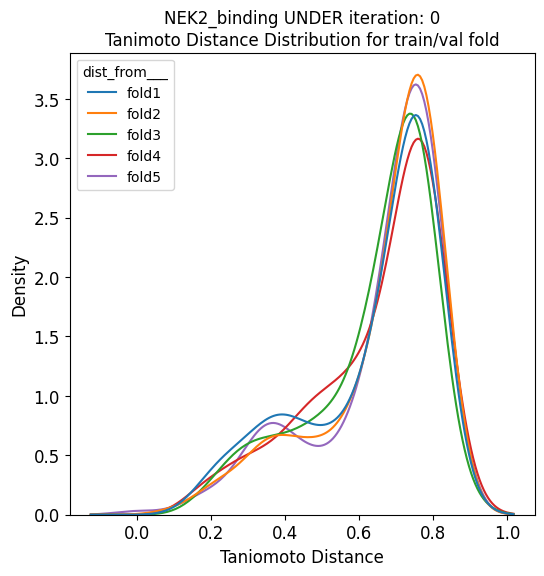

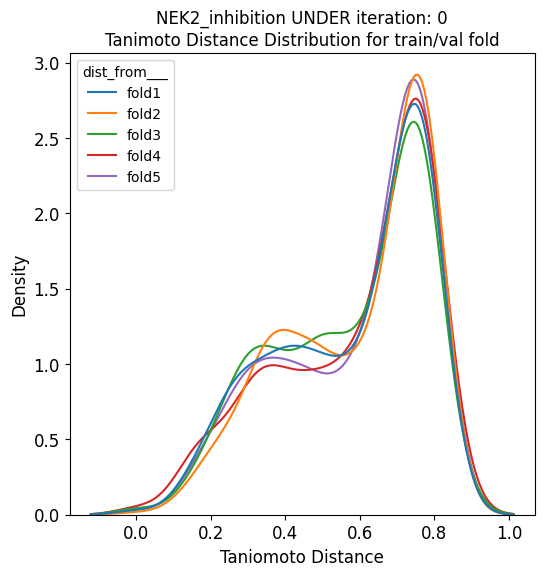

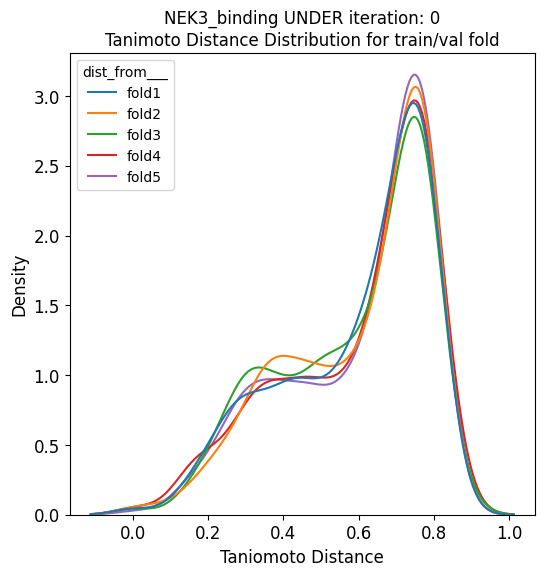

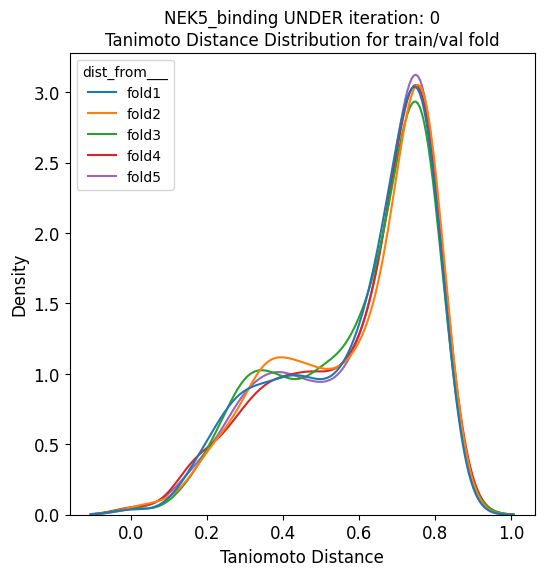

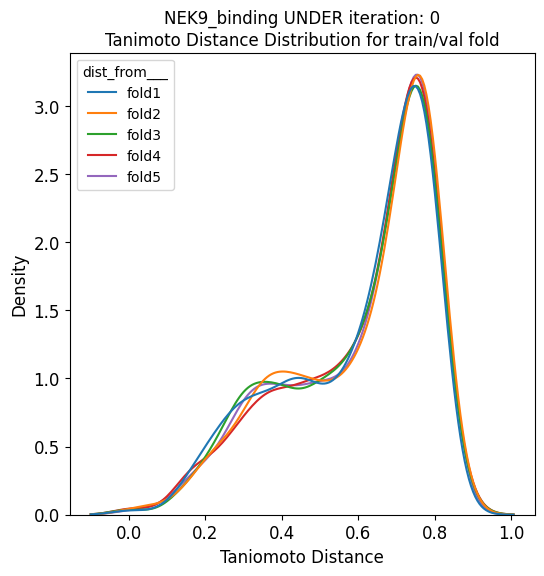

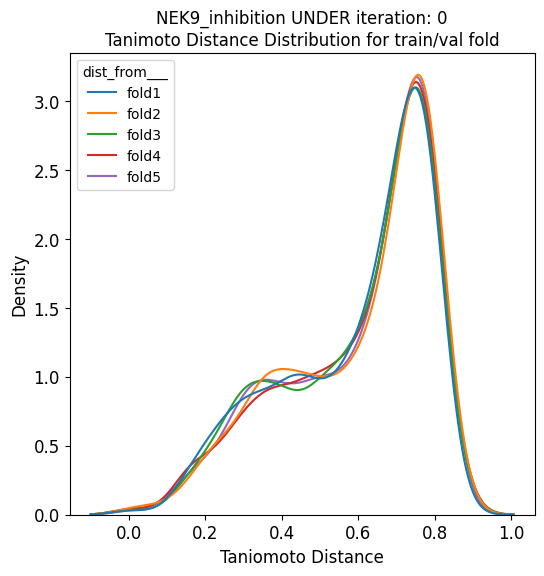

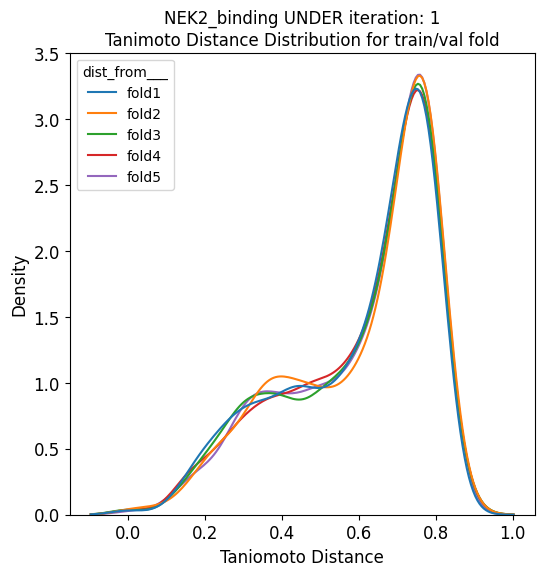

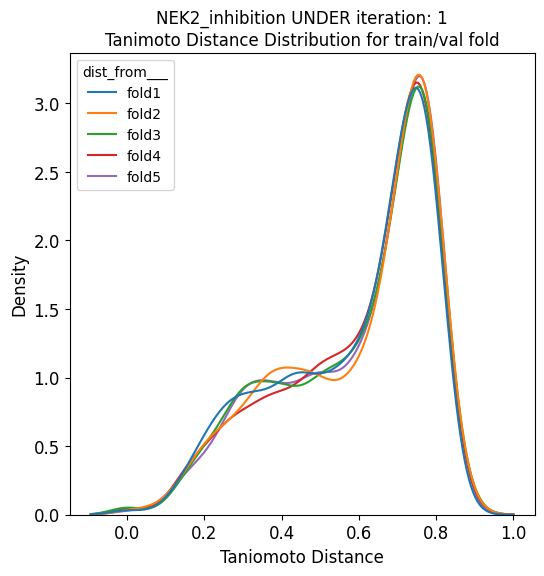

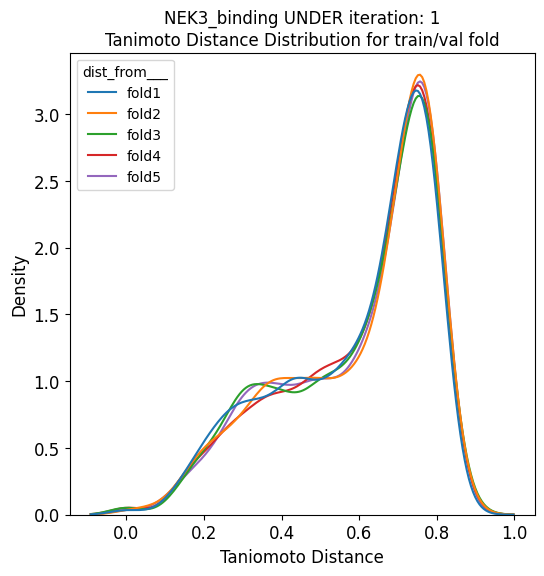

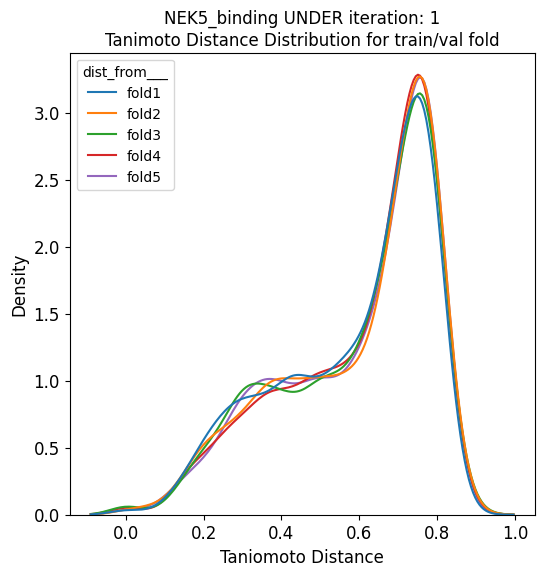

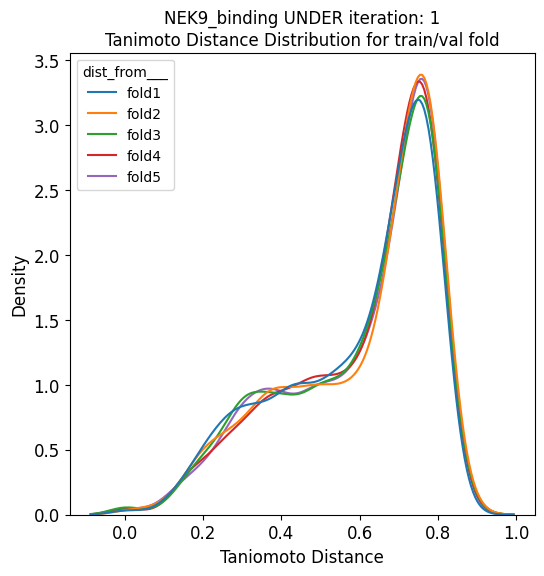

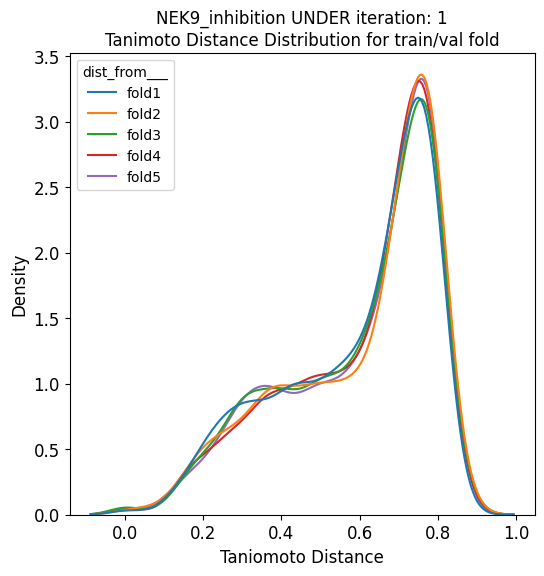

In [28]:

neks = ['NEK2_binding','NEK2_inhibition','NEK3_binding','NEK5_binding','NEK9_binding','NEK9_inhibition']
samplings =['none_scaled','UNDER','SMOTE','ADASYN'] 
feats=['MFP'] 
RF_types = ['RF','RF_BCW','BRFC','BRFC_BCW']
train_results = []
test_results=[]
final_cols=['model','NEK','strategy','feat_type','RF_type', 'cm','recall', 'specificity', 'accuracy', 'precision', 
            'f1', 'ROC_AUC', 'MCC', 'balanced_accuracy', 'fold', 'iteration']
folds=['fold1','fold2','fold3','fold4','fold5']
rng = np.random.default_rng(seed=42) # Create a Generator object with a seed 
numbers = rng.integers(low=0, high=1e6, size=10)  # Generate random numbers
print(numbers)
count=0
fold_labels = [] #the list ofwhich fold is the validation fold 
kfold_dists = []
for i, num in enumerate(list(numbers[0:2])): 
    for nek in neks:   
        split_df = pd.read_csv(f'{datapath}{nek}_MFP_none_scaled.csv')
        train=split_df[split_df['subset']=='train'] 
        folded_train_df = create_folds(train,num) # 5 fold split (validation models) in this iteration 
        for fold in folds: # then use these 5 folds for train/validation 
            kfold_df=label_subsets(folded_train_df, fold, 'test') 

            featurized_df = featurize(feat_type='MFP', df=kfold_df,mfp_radius=2, nBits=2048)
            sampled_df = under_sampling(data_path=None,filename=None,df=featurized_df)  
            id_cols = ['NEK', 'compound_id','base_rdkit_smiles','subset', 'active'] 
            sampled_df=sampled_df.rename(columns=mfp_dict)
            fold_labels.append(fold) 

            dists = get_tani_dist_distr(sampled_df,'base_rdkit_smiles', radius=2, subset_col='subset', subsets=True, ref_subset='test')
            dists['dist_from___'] = fold

            kfold_dists.append(dists)
        all_kfold_dists = pd.concat(kfold_dists)
        # fig, ax = plt.subplots(1, figsize=(6,6), dpi=300)
        fig, ax = plt.subplots(1, figsize=(6,6))
    
        sns.kdeplot(data=all_kfold_dists, x='dist', hue='dist_from___', legend=True, common_norm=False, common_grid=True, fill=False, ax=ax)
        ax.set_xlabel('Taniomoto Distance')
        ax.set_ylabel('Density')
        ax.set_title(f'{nek} UNDER iteration: {i}\nTanimoto Distance Distribution for train/val fold')
        plt.savefig(f'kfold_tani_dists/{nek}_UNDER_it{i}.png')
            # trainX, train_y, testX, test_y=get_arrays(file_path=None, root_name=None, df=sampled_df,nonfeat_cols=id_cols)
                
            

Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([], dtype='object')
train
Index([]

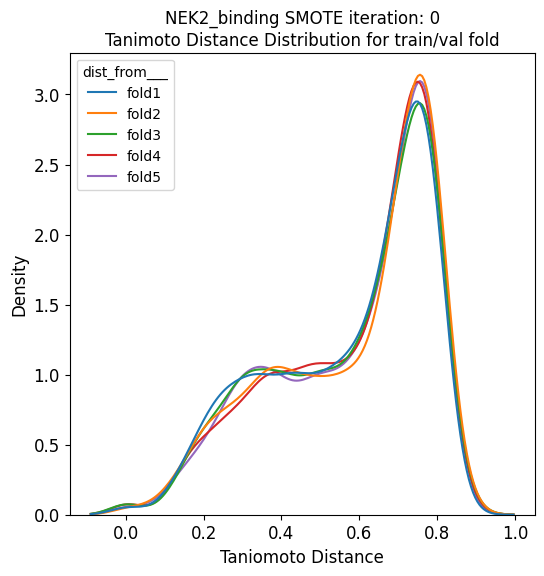

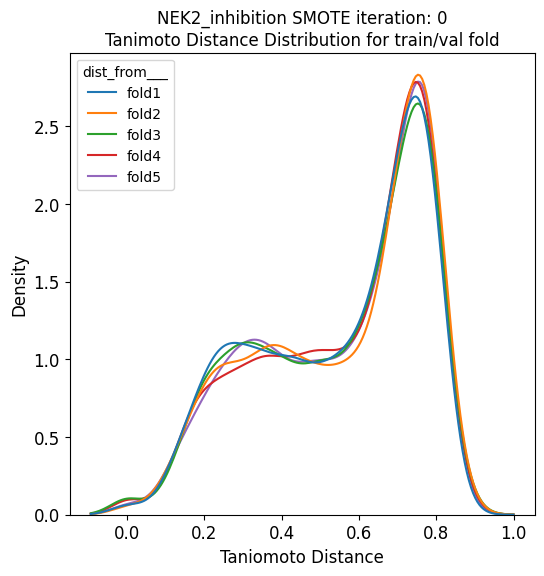

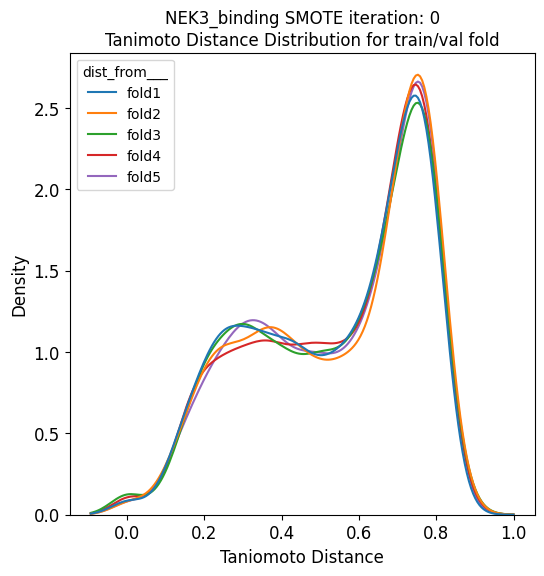

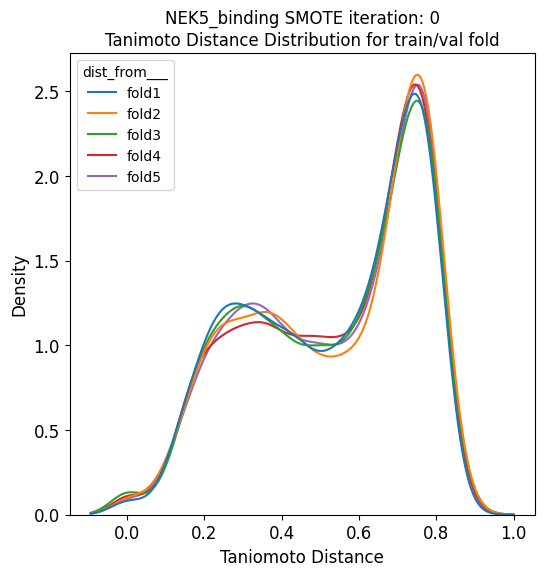

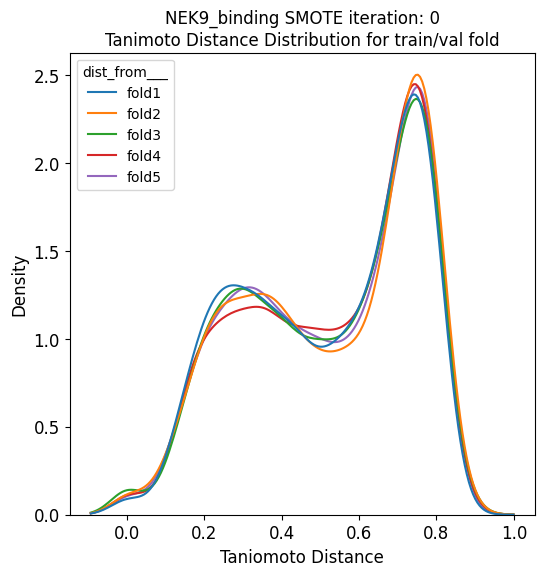

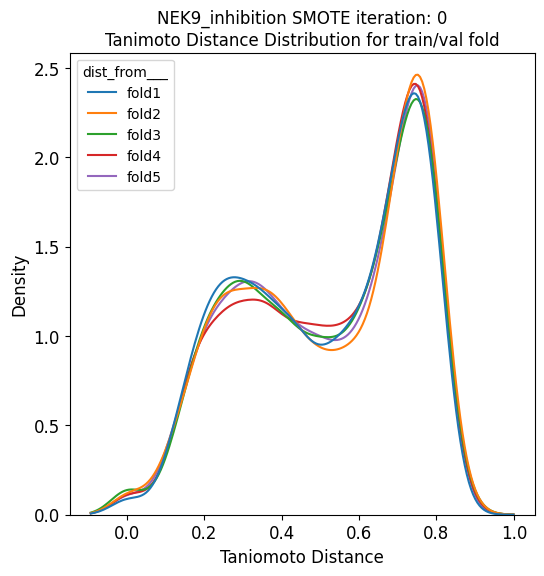

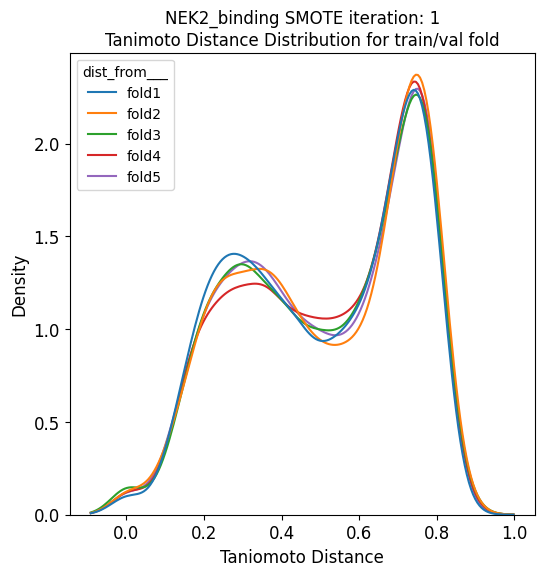

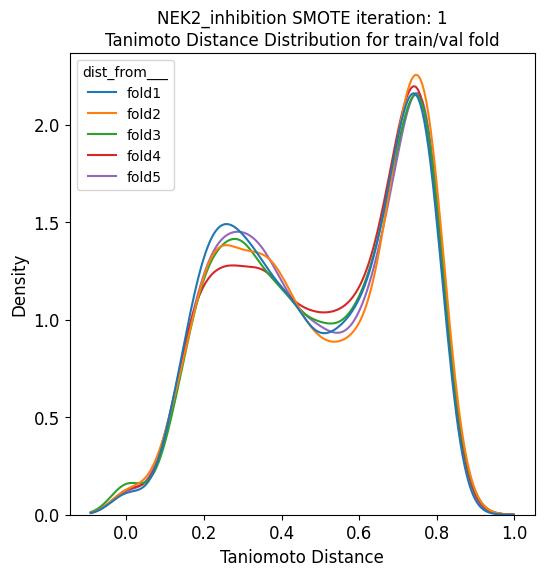

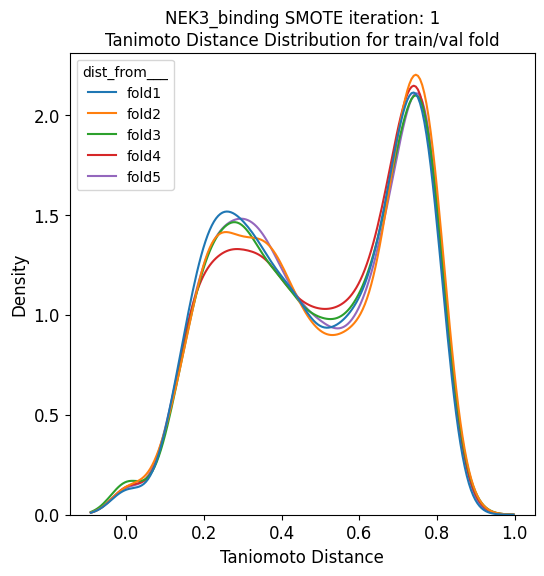

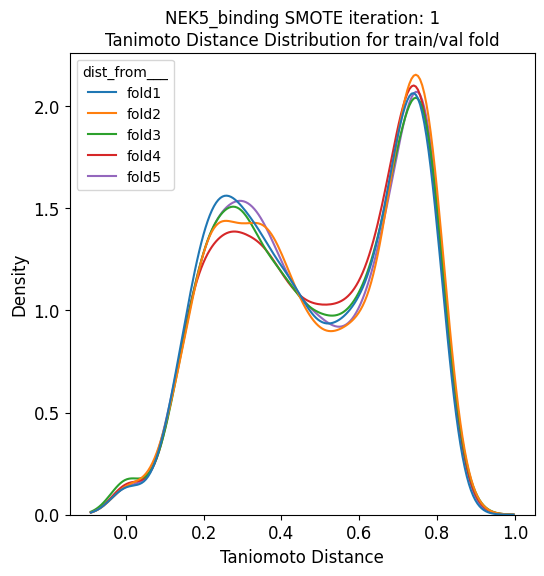

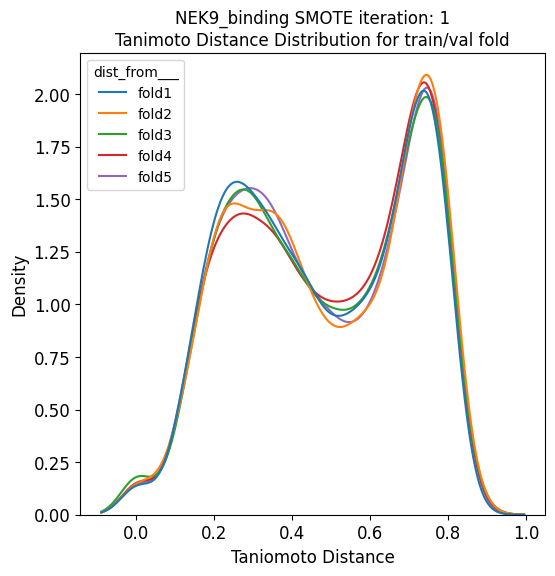

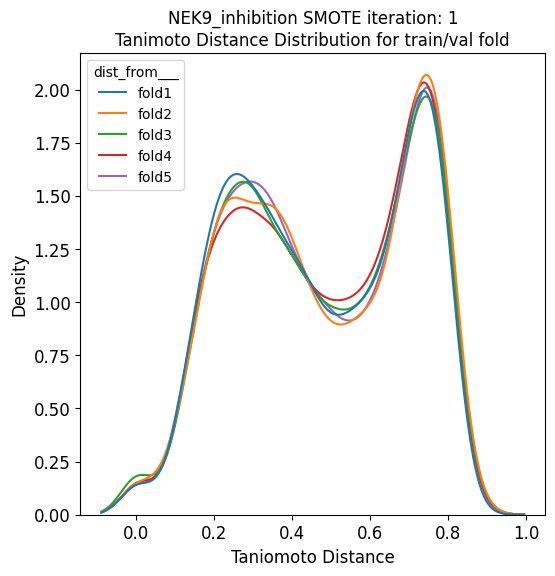

In [29]:
for i, num in enumerate(list(numbers[0:2])): 
    for nek in neks:   
        split_df = pd.read_csv(f'{datapath}{nek}_MFP_none_scaled.csv')
        train=split_df[split_df['subset']=='train'] 
        folded_train_df = create_folds(train,num) # 5 fold split (validation models) in this iteration 
        for fold in folds: # then use these 5 folds for train/validation 
            kfold_df=label_subsets(folded_train_df, fold, 'test') 

            featurized_df = featurize(feat_type='MFP', df=kfold_df,mfp_radius=2, nBits=2048)
            sampled_df = over_sampling(data_path=None,filename=None,df=featurized_df, sampling='SMOTE')  
            id_cols = ['NEK', 'compound_id','base_rdkit_smiles','subset', 'active'] 
            
            fold_labels.append(fold) 

            sampled_df=sampled_df.rename(columns=mfp_dict)
            dists = get_tani_dist_distr(sampled_df,'base_rdkit_smiles', radius=2, subset_col='subset', subsets=True, ref_subset='test')
            dists['dist_from___'] = fold

            kfold_dists.append(dists)
        all_kfold_dists = pd.concat(kfold_dists)
        # fig, ax = plt.subplots(1, figsize=(6,6), dpi=300)
        fig, ax = plt.subplots(1, figsize=(6,6))
    
        sns.kdeplot(data=all_kfold_dists, x='dist', hue='dist_from___', legend=True, common_norm=False, common_grid=True, fill=False, ax=ax)
        ax.set_xlabel('Taniomoto Distance')
        ax.set_ylabel('Density')
        ax.set_title(f'{nek} SMOTE iteration: {i}\nTanimoto Distance Distribution for train/val fold')
        plt.savefig(f'kfold_tani_dists/{nek}_SMOTE_it{i}.png')
                

train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train


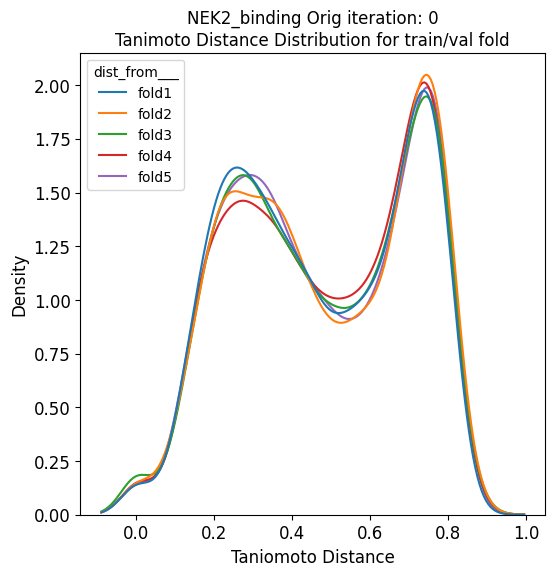

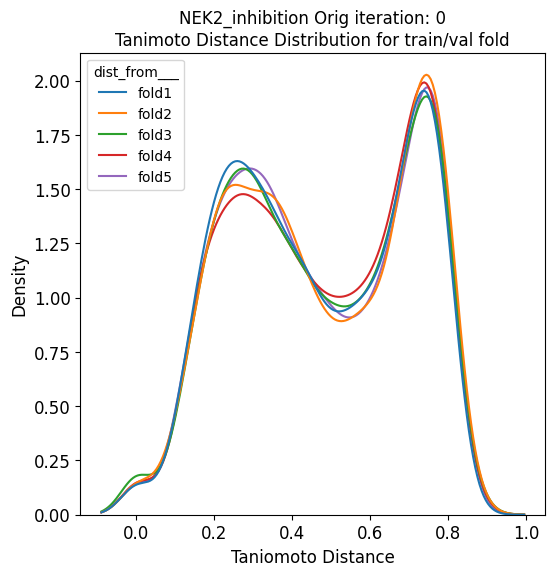

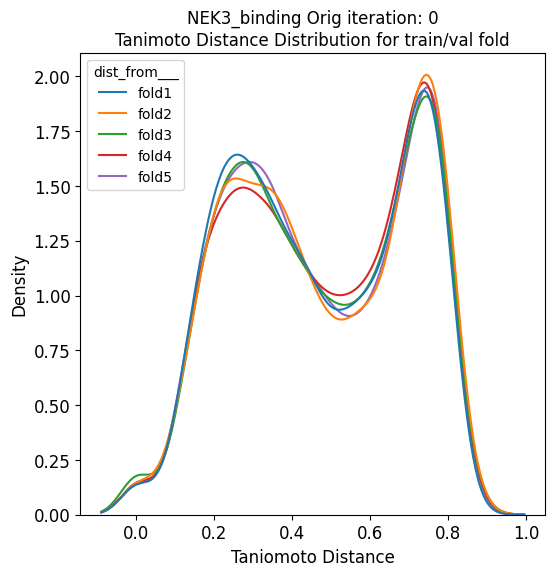

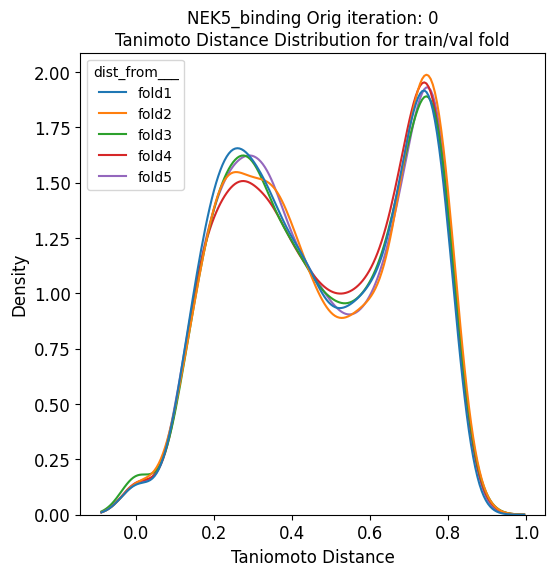

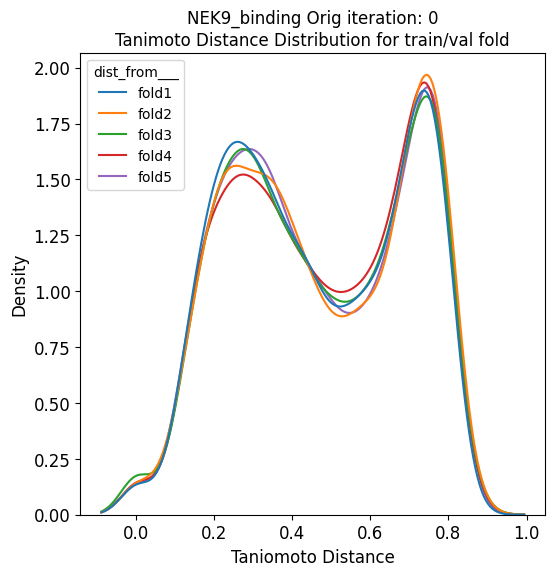

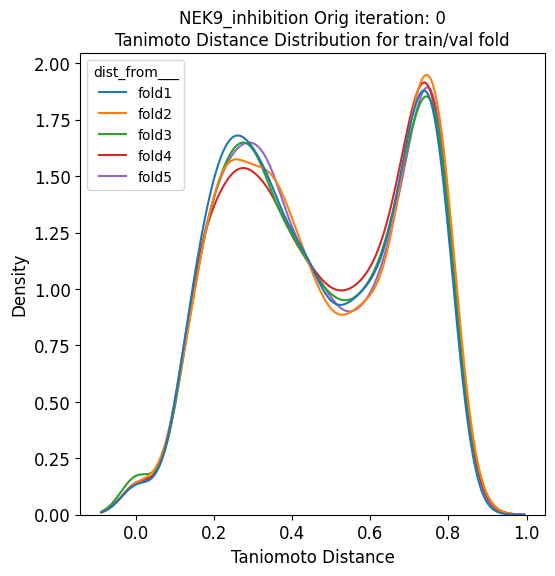

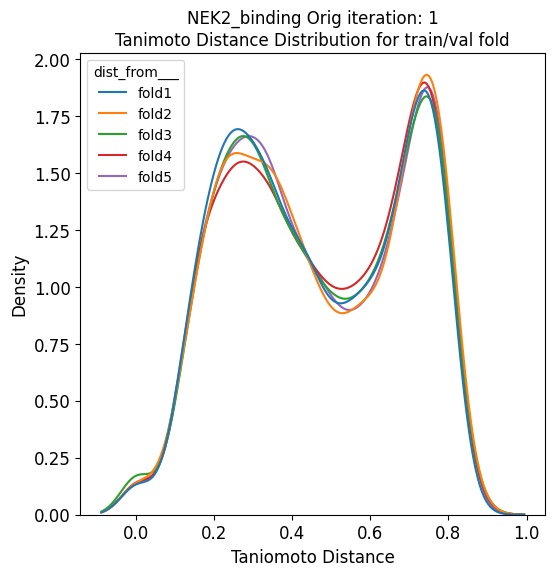

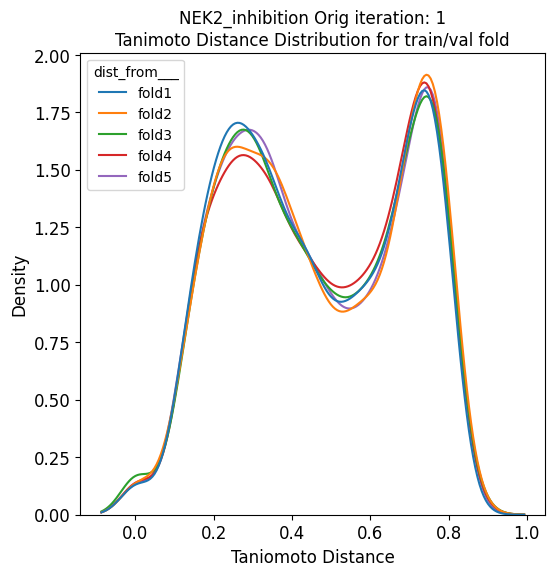

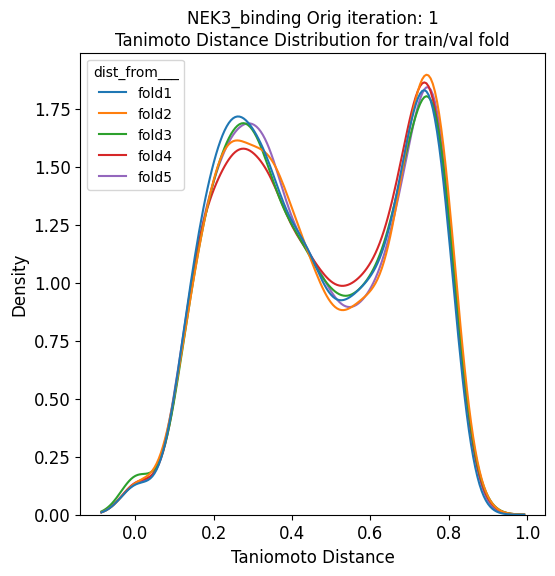

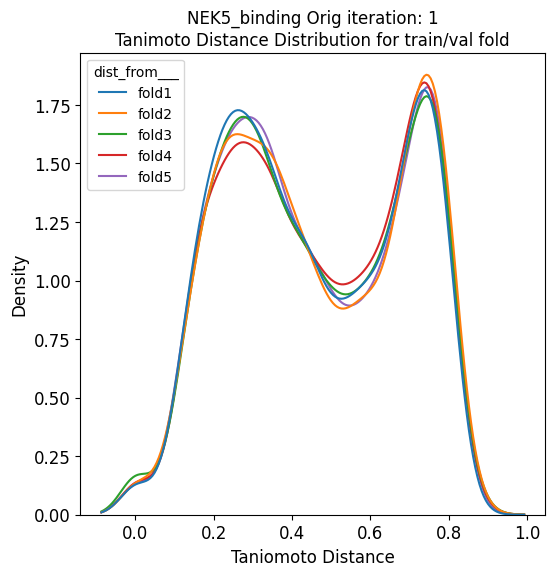

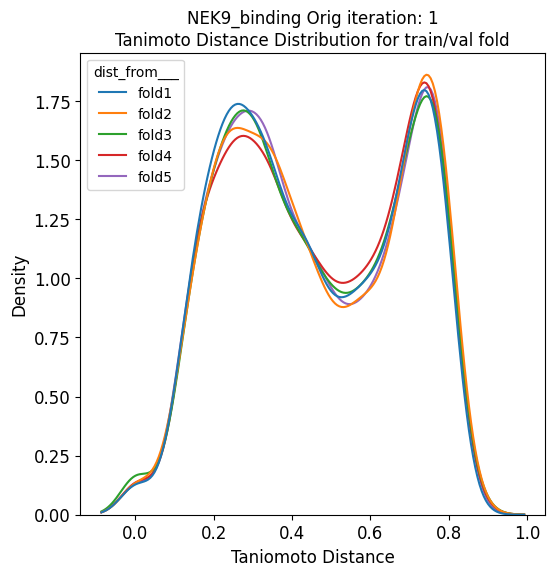

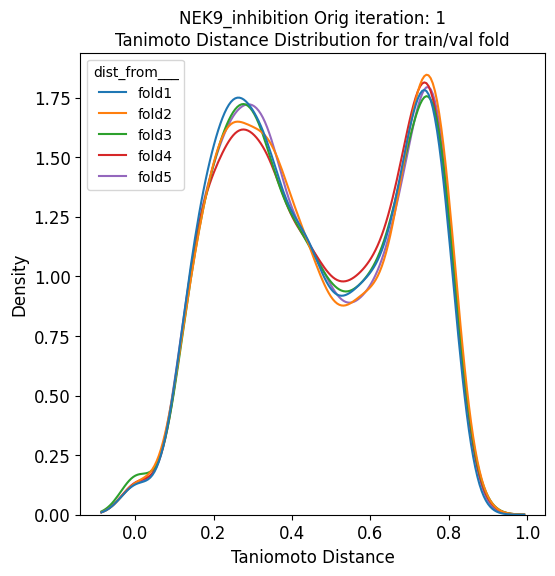

In [31]:
for i, num in enumerate(list(numbers[0:2])): 
    for nek in neks:   
        split_df = pd.read_csv(f'{datapath}{nek}_MFP_none_scaled.csv')
        train=split_df[split_df['subset']=='train'] 
        folded_train_df = create_folds(train,num) # 5 fold split (validation models) in this iteration 
        for fold in folds: # then use these 5 folds for train/validation 
            kfold_df=label_subsets(folded_train_df, fold, 'test') 

            featurized_df = featurize(feat_type='MFP', df=kfold_df,mfp_radius=2, nBits=2048)
            
            dists = get_tani_dist_distr(sampled_df,'base_rdkit_smiles', radius=2, subset_col='subset', subsets=True, ref_subset='test')
            dists['dist_from___'] = fold
            sampled_df=sampled_df.rename(columns=mfp_dict)

            kfold_dists.append(dists)
        all_kfold_dists = pd.concat(kfold_dists)
        # fig, ax = plt.subplots(1, figsize=(6,6), dpi=300)
        fig, ax = plt.subplots(1, figsize=(6,6))
    
        sns.kdeplot(data=all_kfold_dists, x='dist', hue='dist_from___', legend=True, common_norm=False, common_grid=True, fill=False, ax=ax)
        ax.set_xlabel('Taniomoto Distance')
        ax.set_ylabel('Density')
        ax.set_title(f'{nek} Orig iteration: {i}\nTanimoto Distance Distribution for train/val fold')
        plt.savefig(f'kfold_tani_dists/{nek}_Orig_it{i}.png')